In [1]:
import torch
from super_gradients.training import models
from torchinfo import summary
import numpy as np
import math
from numpy import random
import cv2
from roboflow import Roboflow
from super_gradients.training import Trainer
from super_gradients.training.dataloaders.dataloaders import (
    coco_detection_yolo_format_train, coco_detection_yolo_format_val)
from super_gradients.training.losses import PPYoloELoss
from super_gradients.training.metrics import DetectionMetrics_050, DetectionMetrics_050_095
from super_gradients.training.models.detection_models.pp_yolo_e import PPYoloEPostPredictionCallback
import logging
#logging.getLogger("super_gradients").setLevel(logging.WARNING)


The console stream is logged into /home/zw2688/sg_logs/console.log


[2023-11-30 19:00:57] INFO - crash_tips_setup.py - Crash tips is enabled. You can set your environment variable to CRASH_HANDLER=FALSE to disable it
[2023-11-30 19:00:58] WARNING - __init__.py - Failed to import pytorch_quantization
2023-11-30 19:01:02.845751: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-11-30 19:01:04.367537: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-30 19:01:04.367574: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-30 19:01:04.367635: E tensorflow/compiler/

In [2]:
# model = models.get("yolo_nas_s", pretrained_weights="coco").to('cuda')

# rf = Roboflow(api_key="nz2w1UFnyFrM7e73WOzh")
# project = rf.workspace("nyu-figsb").project("basketballdetection-cki6r")
# dataset = project.version(14).download("yolov5")
!nvidia-smi

In [2]:
LOCATION = "basketballDetection-21"
CLASSES = ['basketball', 'hoop', 'person']
CHECKPOINT_DIR = 'yolonas_checkpoints'
NUM_WORKERS = 6
BATCH_SIZE = 64
MAX_EPOCHS = 150
trainer = Trainer(experiment_name="bball_detect_v21", ckpt_root_dir=CHECKPOINT_DIR)


In [3]:
dataset_params = {
    'data_dir': LOCATION,
    'train_images_dir':'train/images',
    'train_labels_dir':'train/labels',
    'val_images_dir':'val/images',
    'val_labels_dir':'val/labels',
    'test_images_dir':'test/images',
    'test_labels_dir':'test/labels',
    'classes': CLASSES
}

train_data = coco_detection_yolo_format_train(
    dataset_params={
        'data_dir': dataset_params['data_dir'],
        'images_dir': dataset_params['train_images_dir'],
        'labels_dir': dataset_params['train_labels_dir'],
        'classes': dataset_params['classes']
    },
    dataloader_params={
        'batch_size': BATCH_SIZE,
        'num_workers': NUM_WORKERS
    }
)

val_data = coco_detection_yolo_format_val(
    dataset_params={
        'data_dir': dataset_params['data_dir'],
        'images_dir': dataset_params['val_images_dir'],
        'labels_dir': dataset_params['val_labels_dir'],
        'classes': dataset_params['classes']
    },
    dataloader_params={
        'batch_size': BATCH_SIZE,
        'num_workers': NUM_WORKERS
    }
)

test_data = coco_detection_yolo_format_val(
    dataset_params={
        'data_dir': dataset_params['data_dir'],
        'images_dir': dataset_params['test_images_dir'],
        'labels_dir': dataset_params['test_labels_dir'],
        'classes': dataset_params['classes']
    },
    dataloader_params={
        'batch_size': BATCH_SIZE,
        'num_workers': NUM_WORKERS
    }
)

[2023-11-30 19:01:39] INFO - detection_dataset.py - Dataset Initialization in progress. `cache_annotations=True` causes the process to take longer due to full dataset indexing.
Indexing dataset annotations: 100%|██████████| 2068/2068 [00:16<00:00, 124.33it/s]
[2023-11-30 19:01:56] INFO - detection_dataset.py - Dataset Initialization in progress. `cache_annotations=True` causes the process to take longer due to full dataset indexing.
Indexing dataset annotations: 100%|██████████| 591/591 [00:04<00:00, 132.86it/s]
[2023-11-30 19:02:01] INFO - detection_dataset.py - Dataset Initialization in progress. `cache_annotations=True` causes the process to take longer due to full dataset indexing.
Indexing dataset annotations: 100%|██████████| 296/296 [00:01<00:00, 238.85it/s]
[2023-11-30 19:02:02] WARNING - detection_dataset.py - Found 1 invalid bbox that were ignored. For more information, please set `show_all_warnings=True`.


In [4]:
train_data.dataset.transforms.pop(2)

DetectionMixup('additional_samples_count': 1, 'non_empty_targets': True, 'input_dim': (640, 640), 'mixup_scale': [0.5, 1.5], 'prob': 1.0, 'enable_mixup': True, 'flip_prob': 0.5, 'border_value': 114)

In [5]:
resume_path = "/scratch/zw2688/DL_project/yolonas_checkpoints/bball_detect_v21/RUN_20231128_232551_738598/ckpt_latest.pth"

model = models.get("yolo_nas_s", num_classes = 3, checkpoint_path = resume_path)

[2023-11-30 16:46:11] INFO - checkpoint_utils.py - Successfully loaded model weights from /scratch/zw2688/DL_project/yolonas_checkpoints/bball_detect_v21/RUN_20231128_232551_738598/ckpt_latest.pth EMA checkpoint.


In [6]:
train_params = {
    "resume": True,
    "resume_path": resume_path,
    'silent_mode': False,
    "MultiGPUMode": "DP",
    "average_best_models":True,
    "warmup_mode": "LinearEpochLRWarmup",
    "warmup_initial_lr": 1e-6,
    "lr_warmup_epochs": 3,
    "initial_lr": 1e-3,
    "lr_mode": "cosine",
    "cosine_final_lr_ratio": 0.1,
    "optimizer": "Adam",
    "optimizer_params": {"weight_decay": 0.0001},
    "zero_weight_decay_on_bias_and_bn": True,
    "ema": True,
    "ema_params": {"decay": 0.9, "decay_type": "threshold"},
    "max_epochs": MAX_EPOCHS,
    "mixed_precision": True,
    "loss": PPYoloELoss(
        use_static_assigner=False,
        num_classes=len(dataset_params['classes']),
        reg_max=16
    ),
    "valid_metrics_list": [
        DetectionMetrics_050(
            score_thres=0.1,
            top_k_predictions=300,
            num_cls=len(dataset_params['classes']),
            normalize_targets=True,
            post_prediction_callback=PPYoloEPostPredictionCallback(
                score_threshold=0.01,
                nms_top_k=1000,
                max_predictions=300,
                nms_threshold=0.7
            )
        ),
        DetectionMetrics_050_095(
            score_thres=0.1,
            top_k_predictions=300,
            num_cls=len(dataset_params['classes']),
            normalize_targets=True,
            post_prediction_callback=PPYoloEPostPredictionCallback(
                score_threshold=0.01,
                nms_top_k=1000,
                max_predictions=300,
                nms_threshold=0.7
            )
        )
    ],
    "metric_to_watch": 'mAP@0.50:0.95'
}

In [7]:
trainer.train(
    model=model,
    training_params=train_params,
    train_loader=train_data,
    valid_loader=val_data
)

[2023-11-30 16:46:11] INFO - sg_trainer.py - Starting a new run with `run_id=RUN_20231130_164611_350170`
[2023-11-30 16:46:11] INFO - sg_trainer.py - Checkpoints directory: yolonas_checkpoints/bball_detect_v21/RUN_20231130_164611_350170
[2023-11-30 16:46:11] INFO - checkpoint_utils.py - Successfully loaded model weights from /scratch/zw2688/DL_project/yolonas_checkpoints/bball_detect_v21/RUN_20231128_232551_738598/ckpt_latest.pth checkpoint.
[2023-11-30 16:46:11] WARNING - sg_trainer.py - [WARNING] Main network has been loaded from checkpoint but EMA network exists as well. It  will only be loaded during validation when training with ema=True. 
[2023-11-30 16:46:11] INFO - sg_trainer.py - Using EMA with params {'decay': 0.9, 'decay_type': 'threshold'}


The console stream is now moved to yolonas_checkpoints/bball_detect_v21/RUN_20231130_164611_350170/console_Nov30_16_46_11.txt


[2023-11-30 16:46:24] INFO - sg_trainer_utils.py - TRAINING PARAMETERS:
    - Mode:                         Single GPU
    - Number of GPUs:               1          (1 available on the machine)
    - Full dataset size:            2067       (len(train_set))
    - Batch size per GPU:           64         (batch_size)
    - Batch Accumulate:             1          (batch_accumulate)
    - Total batch size:             64         (num_gpus * batch_size)
    - Effective Batch size:         64         (num_gpus * batch_size * batch_accumulate)
    - Iterations per epoch:         32         (len(train_loader))
    - Gradient updates per epoch:   32         (len(train_loader) / batch_accumulate)

[2023-11-30 16:46:24] INFO - sg_trainer.py - Started training for 81 epochs (69/149)

Validating epoch 69: 100%|██████████| 10/10 [00:12<00:00,  1.24s/it]


SUMMARY OF EPOCH 69
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.6296
│   ├── Ppyoloeloss/loss_iou = 0.1375
│   ├── Ppyoloeloss/loss_dfl = 0.7273
│   └── Ppyoloeloss/loss = 1.3368
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6525
    ├── Ppyoloeloss/loss_iou = 0.1593
    ├── Ppyoloeloss/loss_dfl = 0.7674
    ├── Ppyoloeloss/loss = 1.4344
    ├── Precision@0.50 = 0.3288
    ├── Recall@0.50 = 0.9289
    ├── Map@0.50 = 0.8856
    ├── F1@0.50 = 0.4821
    ├── Precision@0.50:0.95 = 0.2374
    ├── Recall@0.50:0.95 = 0.6686
    ├── Map@0.50:0.95 = 0.5913
    └── F1@0.50:0.95 = 0.3477



Validating epoch 70: 100%|██████████| 10/10 [00:11<00:00,  1.20s/it]


SUMMARY OF EPOCH 70
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.6259
│   │   ├── Epoch N-1      = 0.6296 (↘ -0.0036)
│   │   └── Best until now = 0.6296 (↘ -0.0036)
│   ├── Ppyoloeloss/loss_iou = 0.1373
│   │   ├── Epoch N-1      = 0.1375 (↘ -1e-04)
│   │   └── Best until now = 0.1375 (↘ -1e-04)
│   ├── Ppyoloeloss/loss_dfl = 0.7222
│   │   ├── Epoch N-1      = 0.7273 (↘ -0.005)
│   │   └── Best until now = 0.7273 (↘ -0.005)
│   └── Ppyoloeloss/loss = 1.3304
│       ├── Epoch N-1      = 1.3368 (↘ -0.0064)
│       └── Best until now = 1.3368 (↘ -0.0064)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6485
    │   ├── Epoch N-1      = 0.6525 (↘ -0.004)
    │   └── Best until now = 0.6525 (↘ -0.004)
    ├── Ppyoloeloss/loss_iou = 0.1592
    │   ├── Epoch N-1      = 0.1593 (↘ -1e-04)
    │   └── Best until now = 0.1593 (↘ -1e-04)
    ├── Ppyoloeloss/loss_dfl = 0.7683
    │   ├── Epoch N-1      = 0.7674 (↗ 0.0009)
    │   └── Best until now = 0.7674 (↗ 0.0009)
    ├── Ppyoloeloss/loss = 1.43

Validating epoch 71: 100%|██████████| 10/10 [00:12<00:00,  1.20s/it]


SUMMARY OF EPOCH 71
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.6228
│   │   ├── Epoch N-1      = 0.6259 (↘ -0.0032)
│   │   └── Best until now = 0.6259 (↘ -0.0032)
│   ├── Ppyoloeloss/loss_iou = 0.1361
│   │   ├── Epoch N-1      = 0.1373 (↘ -0.0013)
│   │   └── Best until now = 0.1373 (↘ -0.0013)
│   ├── Ppyoloeloss/loss_dfl = 0.7201
│   │   ├── Epoch N-1      = 0.7222 (↘ -0.0021)
│   │   └── Best until now = 0.7222 (↘ -0.0021)
│   └── Ppyoloeloss/loss = 1.323
│       ├── Epoch N-1      = 1.3304 (↘ -0.0074)
│       └── Best until now = 1.3304 (↘ -0.0074)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6524
    │   ├── Epoch N-1      = 0.6485 (↗ 0.0039)
    │   └── Best until now = 0.6485 (↗ 0.0039)
    ├── Ppyoloeloss/loss_iou = 0.1513
    │   ├── Epoch N-1      = 0.1592 (↘ -0.008)
    │   └── Best until now = 0.1592 (↘ -0.008)
    ├── Ppyoloeloss/loss_dfl = 0.7456
    │   ├── Epoch N-1      = 0.7683 (↘ -0.0227)
    │   └── Best until now = 0.7674 (↘ -0.0218)
    ├── Ppyoloeloss/loss =

Validating epoch 72: 100%|██████████| 10/10 [00:11<00:00,  1.19s/it]


SUMMARY OF EPOCH 72
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.6235
│   │   ├── Epoch N-1      = 0.6228 (↗ 0.0007)
│   │   └── Best until now = 0.6228 (↗ 0.0007)
│   ├── Ppyoloeloss/loss_iou = 0.137
│   │   ├── Epoch N-1      = 0.1361 (↗ 0.0009)
│   │   └── Best until now = 0.1361 (↗ 0.0009)
│   ├── Ppyoloeloss/loss_dfl = 0.7207
│   │   ├── Epoch N-1      = 0.7201 (↗ 0.0006)
│   │   └── Best until now = 0.7201 (↗ 0.0006)
│   └── Ppyoloeloss/loss = 1.3263
│       ├── Epoch N-1      = 1.323  (↗ 0.0033)
│       └── Best until now = 1.323  (↗ 0.0033)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6422
    │   ├── Epoch N-1      = 0.6524 (↘ -0.0103)
    │   └── Best until now = 0.6485 (↘ -0.0063)
    ├── Ppyoloeloss/loss_iou = 0.148
    │   ├── Epoch N-1      = 0.1513 (↘ -0.0033)
    │   └── Best until now = 0.1513 (↘ -0.0033)
    ├── Ppyoloeloss/loss_dfl = 0.737
    │   ├── Epoch N-1      = 0.7456 (↘ -0.0085)
    │   └── Best until now = 0.7456 (↘ -0.0085)
    ├── Ppyoloeloss/loss = 1.380

Validating epoch 73: 100%|██████████| 10/10 [00:12<00:00,  1.21s/it]


SUMMARY OF EPOCH 73
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.629
│   │   ├── Epoch N-1      = 0.6235 (↗ 0.0055)
│   │   └── Best until now = 0.6228 (↗ 0.0062)
│   ├── Ppyoloeloss/loss_iou = 0.1365
│   │   ├── Epoch N-1      = 0.137  (↘ -0.0005)
│   │   └── Best until now = 0.1361 (↗ 0.0004)
│   ├── Ppyoloeloss/loss_dfl = 0.7272
│   │   ├── Epoch N-1      = 0.7207 (↗ 0.0065)
│   │   └── Best until now = 0.7201 (↗ 0.0071)
│   └── Ppyoloeloss/loss = 1.3338
│       ├── Epoch N-1      = 1.3263 (↗ 0.0075)
│       └── Best until now = 1.323  (↗ 0.0108)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6645
    │   ├── Epoch N-1      = 0.6422 (↗ 0.0223)
    │   └── Best until now = 0.6422 (↗ 0.0223)
    ├── Ppyoloeloss/loss_iou = 0.1704
    │   ├── Epoch N-1      = 0.148  (↗ 0.0224)
    │   └── Best until now = 0.148  (↗ 0.0224)
    ├── Ppyoloeloss/loss_dfl = 0.786
    │   ├── Epoch N-1      = 0.737  (↗ 0.0489)
    │   └── Best until now = 0.737  (↗ 0.0489)
    ├── Ppyoloeloss/loss = 1.4834
  

Validating epoch 74: 100%|██████████| 10/10 [00:11<00:00,  1.19s/it]
[2023-11-30 16:51:53] INFO - base_sg_logger.py - Checkpoint saved in yolonas_checkpoints/bball_detect_v21/RUN_20231130_164611_350170/ckpt_best.pth
[2023-11-30 16:51:53] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50:0.95: 0.6253067851066589


SUMMARY OF EPOCH 74
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.6174
│   │   ├── Epoch N-1      = 0.629  (↘ -0.0115)
│   │   └── Best until now = 0.6228 (↘ -0.0053)
│   ├── Ppyoloeloss/loss_iou = 0.1351
│   │   ├── Epoch N-1      = 0.1365 (↘ -0.0014)
│   │   └── Best until now = 0.1361 (↘ -0.001)
│   ├── Ppyoloeloss/loss_dfl = 0.7178
│   │   ├── Epoch N-1      = 0.7272 (↘ -0.0094)
│   │   └── Best until now = 0.7201 (↘ -0.0023)
│   └── Ppyoloeloss/loss = 1.314
│       ├── Epoch N-1      = 1.3338 (↘ -0.0197)
│       └── Best until now = 1.323  (↘ -0.0089)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.635
    │   ├── Epoch N-1      = 0.6645 (↘ -0.0295)
    │   └── Best until now = 0.6422 (↘ -0.0072)
    ├── Ppyoloeloss/loss_iou = 0.1426
    │   ├── Epoch N-1      = 0.1704 (↘ -0.0278)
    │   └── Best until now = 0.148  (↘ -0.0053)
    ├── Ppyoloeloss/loss_dfl = 0.7298
    │   ├── Epoch N-1      = 0.786  (↘ -0.0562)
    │   └── Best until now = 0.737  (↘ -0.0073)
    ├── Ppyoloeloss/loss

Validating epoch 75: 100%|██████████| 10/10 [00:12<00:00,  1.21s/it]


SUMMARY OF EPOCH 75
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.6212
│   │   ├── Epoch N-1      = 0.6174 (↗ 0.0038)
│   │   └── Best until now = 0.6174 (↗ 0.0038)
│   ├── Ppyoloeloss/loss_iou = 0.1359
│   │   ├── Epoch N-1      = 0.1351 (↗ 0.0008)
│   │   └── Best until now = 0.1351 (↗ 0.0008)
│   ├── Ppyoloeloss/loss_dfl = 0.7234
│   │   ├── Epoch N-1      = 0.7178 (↗ 0.0056)
│   │   └── Best until now = 0.7178 (↗ 0.0056)
│   └── Ppyoloeloss/loss = 1.3225
│       ├── Epoch N-1      = 1.314  (↗ 0.0085)
│       └── Best until now = 1.314  (↗ 0.0085)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6479
    │   ├── Epoch N-1      = 0.635  (↗ 0.0129)
    │   └── Best until now = 0.635  (↗ 0.0129)
    ├── Ppyoloeloss/loss_iou = 0.1524
    │   ├── Epoch N-1      = 0.1426 (↗ 0.0098)
    │   └── Best until now = 0.1426 (↗ 0.0098)
    ├── Ppyoloeloss/loss_dfl = 0.7552
    │   ├── Epoch N-1      = 0.7298 (↗ 0.0254)
    │   └── Best until now = 0.7298 (↗ 0.0254)
    ├── Ppyoloeloss/loss = 1.4064
 

Validating epoch 76: 100%|██████████| 10/10 [00:12<00:00,  1.20s/it]


SUMMARY OF EPOCH 76
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.6182
│   │   ├── Epoch N-1      = 0.6212 (↘ -0.003)
│   │   └── Best until now = 0.6174 (↗ 0.0007)
│   ├── Ppyoloeloss/loss_iou = 0.1351
│   │   ├── Epoch N-1      = 0.1359 (↘ -0.0007)
│   │   └── Best until now = 0.1351 (↗ 1e-04)
│   ├── Ppyoloeloss/loss_dfl = 0.7214
│   │   ├── Epoch N-1      = 0.7234 (↘ -0.002)
│   │   └── Best until now = 0.7178 (↗ 0.0035)
│   └── Ppyoloeloss/loss = 1.3167
│       ├── Epoch N-1      = 1.3225 (↘ -0.0058)
│       └── Best until now = 1.314  (↗ 0.0027)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6406
    │   ├── Epoch N-1      = 0.6479 (↘ -0.0073)
    │   └── Best until now = 0.635  (↗ 0.0056)
    ├── Ppyoloeloss/loss_iou = 0.1462
    │   ├── Epoch N-1      = 0.1524 (↘ -0.0062)
    │   └── Best until now = 0.1426 (↗ 0.0036)
    ├── Ppyoloeloss/loss_dfl = 0.7338
    │   ├── Epoch N-1      = 0.7552 (↘ -0.0214)
    │   └── Best until now = 0.7298 (↗ 0.004)
    ├── Ppyoloeloss/loss = 1.372

Validating epoch 77: 100%|██████████| 10/10 [00:12<00:00,  1.22s/it]
[2023-11-30 16:54:40] INFO - base_sg_logger.py - Checkpoint saved in yolonas_checkpoints/bball_detect_v21/RUN_20231130_164611_350170/ckpt_best.pth
[2023-11-30 16:54:40] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50:0.95: 0.6257013082504272


SUMMARY OF EPOCH 77
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.6195
│   │   ├── Epoch N-1      = 0.6182 (↗ 0.0014)
│   │   └── Best until now = 0.6174 (↗ 0.0021)
│   ├── Ppyoloeloss/loss_iou = 0.1358
│   │   ├── Epoch N-1      = 0.1351 (↗ 0.0006)
│   │   └── Best until now = 0.1351 (↗ 0.0007)
│   ├── Ppyoloeloss/loss_dfl = 0.7173
│   │   ├── Epoch N-1      = 0.7214 (↘ -0.0041)
│   │   └── Best until now = 0.7178 (↘ -0.0006)
│   └── Ppyoloeloss/loss = 1.3176
│       ├── Epoch N-1      = 1.3167 (↗ 0.0009)
│       └── Best until now = 1.314  (↗ 0.0035)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.64
    │   ├── Epoch N-1      = 0.6406 (↘ -0.0005)
    │   └── Best until now = 0.635  (↗ 0.005)
    ├── Ppyoloeloss/loss_iou = 0.1457
    │   ├── Epoch N-1      = 0.1462 (↘ -0.0004)
    │   └── Best until now = 0.1426 (↗ 0.0031)
    ├── Ppyoloeloss/loss_dfl = 0.7381
    │   ├── Epoch N-1      = 0.7338 (↗ 0.0043)
    │   └── Best until now = 0.7298 (↗ 0.0084)
    ├── Ppyoloeloss/loss = 1.3735


Validating epoch 78: 100%|██████████| 10/10 [00:12<00:00,  1.22s/it]
[2023-11-30 16:55:35] INFO - base_sg_logger.py - Checkpoint saved in yolonas_checkpoints/bball_detect_v21/RUN_20231130_164611_350170/ckpt_best.pth
[2023-11-30 16:55:35] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50:0.95: 0.6366105675697327


SUMMARY OF EPOCH 78
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.6199
│   │   ├── Epoch N-1      = 0.6195 (↗ 0.0004)
│   │   └── Best until now = 0.6174 (↗ 0.0025)
│   ├── Ppyoloeloss/loss_iou = 0.1352
│   │   ├── Epoch N-1      = 0.1358 (↘ -0.0006)
│   │   └── Best until now = 0.1351 (↗ 1e-04)
│   ├── Ppyoloeloss/loss_dfl = 0.7197
│   │   ├── Epoch N-1      = 0.7173 (↗ 0.0025)
│   │   └── Best until now = 0.7173 (↗ 0.0025)
│   └── Ppyoloeloss/loss = 1.3178
│       ├── Epoch N-1      = 1.3176 (↗ 0.0003)
│       └── Best until now = 1.314  (↗ 0.0038)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6319
    │   ├── Epoch N-1      = 0.64   (↘ -0.0081)
    │   └── Best until now = 0.635  (↘ -0.0031)
    ├── Ppyoloeloss/loss_iou = 0.1402
    │   ├── Epoch N-1      = 0.1457 (↘ -0.0056)
    │   └── Best until now = 0.1426 (↘ -0.0024)
    ├── Ppyoloeloss/loss_dfl = 0.7262
    │   ├── Epoch N-1      = 0.7381 (↘ -0.0119)
    │   └── Best until now = 0.7298 (↘ -0.0036)
    ├── Ppyoloeloss/loss = 1.

Validating epoch 79: 100%|██████████| 10/10 [00:12<00:00,  1.21s/it]


SUMMARY OF EPOCH 79
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.6216
│   │   ├── Epoch N-1      = 0.6199 (↗ 0.0017)
│   │   └── Best until now = 0.6174 (↗ 0.0042)
│   ├── Ppyoloeloss/loss_iou = 0.1344
│   │   ├── Epoch N-1      = 0.1352 (↘ -0.0008)
│   │   └── Best until now = 0.1351 (↘ -0.0007)
│   ├── Ppyoloeloss/loss_dfl = 0.72
│   │   ├── Epoch N-1      = 0.7197 (↗ 0.0003)
│   │   └── Best until now = 0.7173 (↗ 0.0028)
│   └── Ppyoloeloss/loss = 1.3176
│       ├── Epoch N-1      = 1.3178 (↘ -0.0002)
│       └── Best until now = 1.314  (↗ 0.0036)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6338
    │   ├── Epoch N-1      = 0.6319 (↗ 0.0019)
    │   └── Best until now = 0.6319 (↗ 0.0019)
    ├── Ppyoloeloss/loss_iou = 0.1434
    │   ├── Epoch N-1      = 0.1402 (↗ 0.0033)
    │   └── Best until now = 0.1402 (↗ 0.0033)
    ├── Ppyoloeloss/loss_dfl = 0.7272
    │   ├── Epoch N-1      = 0.7262 (↗ 0.001)
    │   └── Best until now = 0.7262 (↗ 0.001)
    ├── Ppyoloeloss/loss = 1.356
   

Validating epoch 80: 100%|██████████| 10/10 [00:12<00:00,  1.22s/it]


SUMMARY OF EPOCH 80
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.6222
│   │   ├── Epoch N-1      = 0.6216 (↗ 0.0006)
│   │   └── Best until now = 0.6174 (↗ 0.0048)
│   ├── Ppyoloeloss/loss_iou = 0.135
│   │   ├── Epoch N-1      = 0.1344 (↗ 0.0006)
│   │   └── Best until now = 0.1344 (↗ 0.0006)
│   ├── Ppyoloeloss/loss_dfl = 0.7214
│   │   ├── Epoch N-1      = 0.72   (↗ 0.0014)
│   │   └── Best until now = 0.7173 (↗ 0.0042)
│   └── Ppyoloeloss/loss = 1.3204
│       ├── Epoch N-1      = 1.3176 (↗ 0.0028)
│       └── Best until now = 1.314  (↗ 0.0064)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6463
    │   ├── Epoch N-1      = 0.6338 (↗ 0.0125)
    │   └── Best until now = 0.6319 (↗ 0.0144)
    ├── Ppyoloeloss/loss_iou = 0.146
    │   ├── Epoch N-1      = 0.1434 (↗ 0.0025)
    │   └── Best until now = 0.1402 (↗ 0.0058)
    ├── Ppyoloeloss/loss_dfl = 0.7325
    │   ├── Epoch N-1      = 0.7272 (↗ 0.0053)
    │   └── Best until now = 0.7262 (↗ 0.0063)
    ├── Ppyoloeloss/loss = 1.3775
   

Validating epoch 81: 100%|██████████| 10/10 [00:12<00:00,  1.21s/it]


SUMMARY OF EPOCH 81
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.6174
│   │   ├── Epoch N-1      = 0.6222 (↘ -0.0048)
│   │   └── Best until now = 0.6174 (↘ -1e-04)
│   ├── Ppyoloeloss/loss_iou = 0.136
│   │   ├── Epoch N-1      = 0.135  (↗ 0.001)
│   │   └── Best until now = 0.1344 (↗ 0.0016)
│   ├── Ppyoloeloss/loss_dfl = 0.7162
│   │   ├── Epoch N-1      = 0.7214 (↘ -0.0052)
│   │   └── Best until now = 0.7173 (↘ -0.0011)
│   └── Ppyoloeloss/loss = 1.3155
│       ├── Epoch N-1      = 1.3204 (↘ -0.0049)
│       └── Best until now = 1.314  (↗ 0.0015)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6516
    │   ├── Epoch N-1      = 0.6463 (↗ 0.0053)
    │   └── Best until now = 0.6319 (↗ 0.0197)
    ├── Ppyoloeloss/loss_iou = 0.1494
    │   ├── Epoch N-1      = 0.146  (↗ 0.0034)
    │   └── Best until now = 0.1402 (↗ 0.0092)
    ├── Ppyoloeloss/loss_dfl = 0.7436
    │   ├── Epoch N-1      = 0.7325 (↗ 0.0111)
    │   └── Best until now = 0.7262 (↗ 0.0174)
    ├── Ppyoloeloss/loss = 1.3968

Validating epoch 82: 100%|██████████| 10/10 [00:12<00:00,  1.23s/it]


SUMMARY OF EPOCH 82
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.6195
│   │   ├── Epoch N-1      = 0.6174 (↗ 0.0021)
│   │   └── Best until now = 0.6174 (↗ 0.0021)
│   ├── Ppyoloeloss/loss_iou = 0.1337
│   │   ├── Epoch N-1      = 0.136  (↘ -0.0023)
│   │   └── Best until now = 0.1344 (↘ -0.0006)
│   ├── Ppyoloeloss/loss_dfl = 0.7133
│   │   ├── Epoch N-1      = 0.7162 (↘ -0.0029)
│   │   └── Best until now = 0.7162 (↘ -0.0029)
│   └── Ppyoloeloss/loss = 1.3105
│       ├── Epoch N-1      = 1.3155 (↘ -0.0051)
│       └── Best until now = 1.314  (↘ -0.0036)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6689
    │   ├── Epoch N-1      = 0.6516 (↗ 0.0173)
    │   └── Best until now = 0.6319 (↗ 0.037)
    ├── Ppyoloeloss/loss_iou = 0.1589
    │   ├── Epoch N-1      = 0.1494 (↗ 0.0095)
    │   └── Best until now = 0.1402 (↗ 0.0187)
    ├── Ppyoloeloss/loss_dfl = 0.7603
    │   ├── Epoch N-1      = 0.7436 (↗ 0.0167)
    │   └── Best until now = 0.7262 (↗ 0.0341)
    ├── Ppyoloeloss/loss = 1.4

Validating epoch 83: 100%|██████████| 10/10 [00:12<00:00,  1.21s/it]


SUMMARY OF EPOCH 83
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.6086
│   │   ├── Epoch N-1      = 0.6195 (↘ -0.0109)
│   │   └── Best until now = 0.6174 (↘ -0.0088)
│   ├── Ppyoloeloss/loss_iou = 0.1314
│   │   ├── Epoch N-1      = 0.1337 (↘ -0.0024)
│   │   └── Best until now = 0.1337 (↘ -0.0024)
│   ├── Ppyoloeloss/loss_dfl = 0.7056
│   │   ├── Epoch N-1      = 0.7133 (↘ -0.0077)
│   │   └── Best until now = 0.7133 (↘ -0.0077)
│   └── Ppyoloeloss/loss = 1.2898
│       ├── Epoch N-1      = 1.3105 (↘ -0.0206)
│       └── Best until now = 1.3105 (↘ -0.0206)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6468
    │   ├── Epoch N-1      = 0.6689 (↘ -0.0221)
    │   └── Best until now = 0.6319 (↗ 0.0149)
    ├── Ppyoloeloss/loss_iou = 0.1544
    │   ├── Epoch N-1      = 0.1589 (↘ -0.0045)
    │   └── Best until now = 0.1402 (↗ 0.0142)
    ├── Ppyoloeloss/loss_dfl = 0.7479
    │   ├── Epoch N-1      = 0.7603 (↘ -0.0124)
    │   └── Best until now = 0.7262 (↗ 0.0217)
    ├── Ppyoloeloss/loss

Validating epoch 84: 100%|██████████| 10/10 [00:12<00:00,  1.20s/it]


SUMMARY OF EPOCH 84
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.6144
│   │   ├── Epoch N-1      = 0.6086 (↗ 0.0058)
│   │   └── Best until now = 0.6086 (↗ 0.0058)
│   ├── Ppyoloeloss/loss_iou = 0.1333
│   │   ├── Epoch N-1      = 0.1314 (↗ 0.0019)
│   │   └── Best until now = 0.1314 (↗ 0.0019)
│   ├── Ppyoloeloss/loss_dfl = 0.7107
│   │   ├── Epoch N-1      = 0.7056 (↗ 0.0052)
│   │   └── Best until now = 0.7056 (↗ 0.0052)
│   └── Ppyoloeloss/loss = 1.303
│       ├── Epoch N-1      = 1.2898 (↗ 0.0131)
│       └── Best until now = 1.2898 (↗ 0.0131)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6366
    │   ├── Epoch N-1      = 0.6468 (↘ -0.0102)
    │   └── Best until now = 0.6319 (↗ 0.0047)
    ├── Ppyoloeloss/loss_iou = 0.146
    │   ├── Epoch N-1      = 0.1544 (↘ -0.0083)
    │   └── Best until now = 0.1402 (↗ 0.0059)
    ├── Ppyoloeloss/loss_dfl = 0.7263
    │   ├── Epoch N-1      = 0.7479 (↘ -0.0217)
    │   └── Best until now = 0.7262 (↗ 1e-04)
    ├── Ppyoloeloss/loss = 1.3648
 

Validating epoch 85: 100%|██████████| 10/10 [00:12<00:00,  1.23s/it]


SUMMARY OF EPOCH 85
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.6089
│   │   ├── Epoch N-1      = 0.6144 (↘ -0.0055)
│   │   └── Best until now = 0.6086 (↗ 0.0003)
│   ├── Ppyoloeloss/loss_iou = 0.1326
│   │   ├── Epoch N-1      = 0.1333 (↘ -0.0006)
│   │   └── Best until now = 0.1314 (↗ 0.0012)
│   ├── Ppyoloeloss/loss_dfl = 0.707
│   │   ├── Epoch N-1      = 0.7107 (↘ -0.0038)
│   │   └── Best until now = 0.7056 (↗ 0.0014)
│   └── Ppyoloeloss/loss = 1.294
│       ├── Epoch N-1      = 1.303  (↘ -0.009)
│       └── Best until now = 1.2898 (↗ 0.0041)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6423
    │   ├── Epoch N-1      = 0.6366 (↗ 0.0057)
    │   └── Best until now = 0.6319 (↗ 0.0104)
    ├── Ppyoloeloss/loss_iou = 0.1437
    │   ├── Epoch N-1      = 0.146  (↘ -0.0024)
    │   └── Best until now = 0.1402 (↗ 0.0035)
    ├── Ppyoloeloss/loss_dfl = 0.7189
    │   ├── Epoch N-1      = 0.7263 (↘ -0.0074)
    │   └── Best until now = 0.7262 (↘ -0.0073)
    ├── Ppyoloeloss/loss = 1.36

Validating epoch 86: 100%|██████████| 10/10 [00:12<00:00,  1.21s/it]


SUMMARY OF EPOCH 86
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.6105
│   │   ├── Epoch N-1      = 0.6089 (↗ 0.0016)
│   │   └── Best until now = 0.6086 (↗ 0.0019)
│   ├── Ppyoloeloss/loss_iou = 0.1312
│   │   ├── Epoch N-1      = 0.1326 (↘ -0.0014)
│   │   └── Best until now = 0.1314 (↘ -0.0002)
│   ├── Ppyoloeloss/loss_dfl = 0.7105
│   │   ├── Epoch N-1      = 0.707  (↗ 0.0036)
│   │   └── Best until now = 0.7056 (↗ 0.0049)
│   └── Ppyoloeloss/loss = 1.2938
│       ├── Epoch N-1      = 1.294  (↘ -0.0002)
│       └── Best until now = 1.2898 (↗ 0.004)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6465
    │   ├── Epoch N-1      = 0.6423 (↗ 0.0042)
    │   └── Best until now = 0.6319 (↗ 0.0145)
    ├── Ppyoloeloss/loss_iou = 0.149
    │   ├── Epoch N-1      = 0.1437 (↗ 0.0053)
    │   └── Best until now = 0.1402 (↗ 0.0088)
    ├── Ppyoloeloss/loss_dfl = 0.7337
    │   ├── Epoch N-1      = 0.7189 (↗ 0.0148)
    │   └── Best until now = 0.7189 (↗ 0.0148)
    ├── Ppyoloeloss/loss = 1.3857


Validating epoch 87: 100%|██████████| 10/10 [00:12<00:00,  1.22s/it]


SUMMARY OF EPOCH 87
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.6084
│   │   ├── Epoch N-1      = 0.6105 (↘ -0.0022)
│   │   └── Best until now = 0.6086 (↘ -0.0002)
│   ├── Ppyoloeloss/loss_iou = 0.1309
│   │   ├── Epoch N-1      = 0.1312 (↘ -0.0003)
│   │   └── Best until now = 0.1312 (↘ -0.0003)
│   ├── Ppyoloeloss/loss_dfl = 0.7081
│   │   ├── Epoch N-1      = 0.7105 (↘ -0.0025)
│   │   └── Best until now = 0.7056 (↗ 0.0025)
│   └── Ppyoloeloss/loss = 1.2897
│       ├── Epoch N-1      = 1.2938 (↘ -0.0041)
│       └── Best until now = 1.2898 (↘ -1e-04)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6398
    │   ├── Epoch N-1      = 0.6465 (↘ -0.0067)
    │   └── Best until now = 0.6319 (↗ 0.0079)
    ├── Ppyoloeloss/loss_iou = 0.1522
    │   ├── Epoch N-1      = 0.149  (↗ 0.0033)
    │   └── Best until now = 0.1402 (↗ 0.0121)
    ├── Ppyoloeloss/loss_dfl = 0.7464
    │   ├── Epoch N-1      = 0.7337 (↗ 0.0126)
    │   └── Best until now = 0.7189 (↗ 0.0275)
    ├── Ppyoloeloss/loss = 1

Validating epoch 88: 100%|██████████| 10/10 [00:12<00:00,  1.22s/it]


SUMMARY OF EPOCH 88
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.6045
│   │   ├── Epoch N-1      = 0.6084 (↘ -0.0039)
│   │   └── Best until now = 0.6084 (↘ -0.0039)
│   ├── Ppyoloeloss/loss_iou = 0.1305
│   │   ├── Epoch N-1      = 0.1309 (↘ -0.0004)
│   │   └── Best until now = 0.1309 (↘ -0.0004)
│   ├── Ppyoloeloss/loss_dfl = 0.7077
│   │   ├── Epoch N-1      = 0.7081 (↘ -0.0004)
│   │   └── Best until now = 0.7056 (↗ 0.0021)
│   └── Ppyoloeloss/loss = 1.2847
│       ├── Epoch N-1      = 1.2897 (↘ -0.005)
│       └── Best until now = 1.2897 (↘ -0.005)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6473
    │   ├── Epoch N-1      = 0.6398 (↗ 0.0075)
    │   └── Best until now = 0.6319 (↗ 0.0154)
    ├── Ppyoloeloss/loss_iou = 0.1554
    │   ├── Epoch N-1      = 0.1522 (↗ 0.0032)
    │   └── Best until now = 0.1402 (↗ 0.0152)
    ├── Ppyoloeloss/loss_dfl = 0.7513
    │   ├── Epoch N-1      = 0.7464 (↗ 0.0049)
    │   └── Best until now = 0.7189 (↗ 0.0323)
    ├── Ppyoloeloss/loss = 1.4

Validating epoch 89: 100%|██████████| 10/10 [00:12<00:00,  1.27s/it]


SUMMARY OF EPOCH 89
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.6137
│   │   ├── Epoch N-1      = 0.6045 (↗ 0.0092)
│   │   └── Best until now = 0.6045 (↗ 0.0092)
│   ├── Ppyoloeloss/loss_iou = 0.1328
│   │   ├── Epoch N-1      = 0.1305 (↗ 0.0023)
│   │   └── Best until now = 0.1305 (↗ 0.0023)
│   ├── Ppyoloeloss/loss_dfl = 0.7139
│   │   ├── Epoch N-1      = 0.7077 (↗ 0.0062)
│   │   └── Best until now = 0.7056 (↗ 0.0083)
│   └── Ppyoloeloss/loss = 1.3027
│       ├── Epoch N-1      = 1.2847 (↗ 0.018)
│       └── Best until now = 1.2847 (↗ 0.018)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6446
    │   ├── Epoch N-1      = 0.6473 (↘ -0.0027)
    │   └── Best until now = 0.6319 (↗ 0.0126)
    ├── Ppyoloeloss/loss_iou = 0.1495
    │   ├── Epoch N-1      = 0.1554 (↘ -0.006)
    │   └── Best until now = 0.1402 (↗ 0.0093)
    ├── Ppyoloeloss/loss_dfl = 0.7424
    │   ├── Epoch N-1      = 0.7513 (↘ -0.0089)
    │   └── Best until now = 0.7189 (↗ 0.0235)
    ├── Ppyoloeloss/loss = 1.3894
 

Validating epoch 90: 100%|██████████| 10/10 [00:12<00:00,  1.22s/it]


SUMMARY OF EPOCH 90
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.6098
│   │   ├── Epoch N-1      = 0.6137 (↘ -0.0039)
│   │   └── Best until now = 0.6045 (↗ 0.0053)
│   ├── Ppyoloeloss/loss_iou = 0.1307
│   │   ├── Epoch N-1      = 0.1328 (↘ -0.0021)
│   │   └── Best until now = 0.1305 (↗ 0.0002)
│   ├── Ppyoloeloss/loss_dfl = 0.7092
│   │   ├── Epoch N-1      = 0.7139 (↘ -0.0048)
│   │   └── Best until now = 0.7056 (↗ 0.0036)
│   └── Ppyoloeloss/loss = 1.2911
│       ├── Epoch N-1      = 1.3027 (↘ -0.0116)
│       └── Best until now = 1.2847 (↗ 0.0064)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6358
    │   ├── Epoch N-1      = 0.6446 (↘ -0.0088)
    │   └── Best until now = 0.6319 (↗ 0.0039)
    ├── Ppyoloeloss/loss_iou = 0.1421
    │   ├── Epoch N-1      = 0.1495 (↘ -0.0073)
    │   └── Best until now = 0.1402 (↗ 0.002)
    ├── Ppyoloeloss/loss_dfl = 0.7233
    │   ├── Epoch N-1      = 0.7424 (↘ -0.019)
    │   └── Best until now = 0.7189 (↗ 0.0044)
    ├── Ppyoloeloss/loss = 1.3

Validating epoch 91: 100%|██████████| 10/10 [00:11<00:00,  1.20s/it]


SUMMARY OF EPOCH 91
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.6035
│   │   ├── Epoch N-1      = 0.6098 (↘ -0.0063)
│   │   └── Best until now = 0.6045 (↘ -0.001)
│   ├── Ppyoloeloss/loss_iou = 0.131
│   │   ├── Epoch N-1      = 0.1307 (↗ 0.0002)
│   │   └── Best until now = 0.1305 (↗ 0.0004)
│   ├── Ppyoloeloss/loss_dfl = 0.7055
│   │   ├── Epoch N-1      = 0.7092 (↘ -0.0037)
│   │   └── Best until now = 0.7056 (↘ -1e-04)
│   └── Ppyoloeloss/loss = 1.2836
│       ├── Epoch N-1      = 1.2911 (↘ -0.0075)
│       └── Best until now = 1.2847 (↘ -0.0011)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6346
    │   ├── Epoch N-1      = 0.6358 (↘ -0.0012)
    │   └── Best until now = 0.6319 (↗ 0.0027)
    ├── Ppyoloeloss/loss_iou = 0.1452
    │   ├── Epoch N-1      = 0.1421 (↗ 0.003)
    │   └── Best until now = 0.1402 (↗ 0.005)
    ├── Ppyoloeloss/loss_dfl = 0.7284
    │   ├── Epoch N-1      = 0.7233 (↗ 0.0051)
    │   └── Best until now = 0.7189 (↗ 0.0095)
    ├── Ppyoloeloss/loss = 1.3617

Validating epoch 92: 100%|██████████| 10/10 [00:12<00:00,  1.22s/it]


SUMMARY OF EPOCH 92
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.6016
│   │   ├── Epoch N-1      = 0.6035 (↘ -0.0019)
│   │   └── Best until now = 0.6035 (↘ -0.0019)
│   ├── Ppyoloeloss/loss_iou = 0.1319
│   │   ├── Epoch N-1      = 0.131  (↗ 0.001)
│   │   └── Best until now = 0.1305 (↗ 0.0014)
│   ├── Ppyoloeloss/loss_dfl = 0.7053
│   │   ├── Epoch N-1      = 0.7055 (↘ -0.0002)
│   │   └── Best until now = 0.7055 (↘ -0.0002)
│   └── Ppyoloeloss/loss = 1.2841
│       ├── Epoch N-1      = 1.2836 (↗ 0.0005)
│       └── Best until now = 1.2836 (↗ 0.0005)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6342
    │   ├── Epoch N-1      = 0.6346 (↘ -0.0004)
    │   └── Best until now = 0.6319 (↗ 0.0022)
    ├── Ppyoloeloss/loss_iou = 0.147
    │   ├── Epoch N-1      = 0.1452 (↗ 0.0018)
    │   └── Best until now = 0.1402 (↗ 0.0068)
    ├── Ppyoloeloss/loss_dfl = 0.7341
    │   ├── Epoch N-1      = 0.7284 (↗ 0.0057)
    │   └── Best until now = 0.7189 (↗ 0.0152)
    ├── Ppyoloeloss/loss = 1.368

Validating epoch 93: 100%|██████████| 10/10 [00:12<00:00,  1.21s/it]


SUMMARY OF EPOCH 93
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.6057
│   │   ├── Epoch N-1      = 0.6016 (↗ 0.0041)
│   │   └── Best until now = 0.6016 (↗ 0.0041)
│   ├── Ppyoloeloss/loss_iou = 0.1305
│   │   ├── Epoch N-1      = 0.1319 (↘ -0.0014)
│   │   └── Best until now = 0.1305 (↘ -0.0)
│   ├── Ppyoloeloss/loss_dfl = 0.7043
│   │   ├── Epoch N-1      = 0.7053 (↘ -0.001)
│   │   └── Best until now = 0.7053 (↘ -0.001)
│   └── Ppyoloeloss/loss = 1.2841
│       ├── Epoch N-1      = 1.2841 (↗ 0.0)
│       └── Best until now = 1.2836 (↗ 0.0005)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6379
    │   ├── Epoch N-1      = 0.6342 (↗ 0.0038)
    │   └── Best until now = 0.6319 (↗ 0.006)
    ├── Ppyoloeloss/loss_iou = 0.15
    │   ├── Epoch N-1      = 0.147  (↗ 0.003)
    │   └── Best until now = 0.1402 (↗ 0.0098)
    ├── Ppyoloeloss/loss_dfl = 0.7433
    │   ├── Epoch N-1      = 0.7341 (↗ 0.0092)
    │   └── Best until now = 0.7189 (↗ 0.0244)
    ├── Ppyoloeloss/loss = 1.3845
    │   ├

Validating epoch 94: 100%|██████████| 10/10 [00:11<00:00,  1.20s/it]


SUMMARY OF EPOCH 94
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.6001
│   │   ├── Epoch N-1      = 0.6057 (↘ -0.0056)
│   │   └── Best until now = 0.6016 (↘ -0.0015)
│   ├── Ppyoloeloss/loss_iou = 0.1298
│   │   ├── Epoch N-1      = 0.1305 (↘ -0.0007)
│   │   └── Best until now = 0.1305 (↘ -0.0007)
│   ├── Ppyoloeloss/loss_dfl = 0.702
│   │   ├── Epoch N-1      = 0.7043 (↘ -0.0023)
│   │   └── Best until now = 0.7043 (↘ -0.0023)
│   └── Ppyoloeloss/loss = 1.2756
│       ├── Epoch N-1      = 1.2841 (↘ -0.0086)
│       └── Best until now = 1.2836 (↘ -0.008)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6341
    │   ├── Epoch N-1      = 0.6379 (↘ -0.0038)
    │   └── Best until now = 0.6319 (↗ 0.0022)
    ├── Ppyoloeloss/loss_iou = 0.145
    │   ├── Epoch N-1      = 0.15   (↘ -0.005)
    │   └── Best until now = 0.1402 (↗ 0.0049)
    ├── Ppyoloeloss/loss_dfl = 0.7311
    │   ├── Epoch N-1      = 0.7433 (↘ -0.0122)
    │   └── Best until now = 0.7189 (↗ 0.0122)
    ├── Ppyoloeloss/loss = 1

Validating epoch 95: 100%|██████████| 10/10 [00:12<00:00,  1.22s/it]


SUMMARY OF EPOCH 95
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.6048
│   │   ├── Epoch N-1      = 0.6001 (↗ 0.0047)
│   │   └── Best until now = 0.6001 (↗ 0.0047)
│   ├── Ppyoloeloss/loss_iou = 0.1305
│   │   ├── Epoch N-1      = 0.1298 (↗ 0.0006)
│   │   └── Best until now = 0.1298 (↗ 0.0006)
│   ├── Ppyoloeloss/loss_dfl = 0.7105
│   │   ├── Epoch N-1      = 0.702  (↗ 0.0086)
│   │   └── Best until now = 0.702  (↗ 0.0086)
│   └── Ppyoloeloss/loss = 1.2862
│       ├── Epoch N-1      = 1.2756 (↗ 0.0106)
│       └── Best until now = 1.2756 (↗ 0.0106)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6364
    │   ├── Epoch N-1      = 0.6341 (↗ 0.0023)
    │   └── Best until now = 0.6319 (↗ 0.0045)
    ├── Ppyoloeloss/loss_iou = 0.1493
    │   ├── Epoch N-1      = 0.145  (↗ 0.0042)
    │   └── Best until now = 0.1402 (↗ 0.0091)
    ├── Ppyoloeloss/loss_dfl = 0.738
    │   ├── Epoch N-1      = 0.7311 (↗ 0.0069)
    │   └── Best until now = 0.7189 (↗ 0.0191)
    ├── Ppyoloeloss/loss = 1.3786
  

Validating epoch 96: 100%|██████████| 10/10 [00:11<00:00,  1.20s/it]


SUMMARY OF EPOCH 96
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.5978
│   │   ├── Epoch N-1      = 0.6048 (↘ -0.0069)
│   │   └── Best until now = 0.6001 (↘ -0.0022)
│   ├── Ppyoloeloss/loss_iou = 0.1277
│   │   ├── Epoch N-1      = 0.1305 (↘ -0.0027)
│   │   └── Best until now = 0.1298 (↘ -0.0021)
│   ├── Ppyoloeloss/loss_dfl = 0.7037
│   │   ├── Epoch N-1      = 0.7105 (↘ -0.0068)
│   │   └── Best until now = 0.702  (↗ 0.0018)
│   └── Ppyoloeloss/loss = 1.269
│       ├── Epoch N-1      = 1.2862 (↘ -0.0172)
│       └── Best until now = 1.2756 (↘ -0.0066)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6319
    │   ├── Epoch N-1      = 0.6364 (↘ -0.0044)
    │   └── Best until now = 0.6319 (↗ 0.0)
    ├── Ppyoloeloss/loss_iou = 0.1451
    │   ├── Epoch N-1      = 0.1493 (↘ -0.0042)
    │   └── Best until now = 0.1402 (↗ 0.0049)
    ├── Ppyoloeloss/loss_dfl = 0.7344
    │   ├── Epoch N-1      = 0.738  (↘ -0.0036)
    │   └── Best until now = 0.7189 (↗ 0.0155)
    ├── Ppyoloeloss/loss = 1.

Validating epoch 97: 100%|██████████| 10/10 [00:11<00:00,  1.19s/it]


SUMMARY OF EPOCH 97
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.5993
│   │   ├── Epoch N-1      = 0.5978 (↗ 0.0015)
│   │   └── Best until now = 0.5978 (↗ 0.0015)
│   ├── Ppyoloeloss/loss_iou = 0.1287
│   │   ├── Epoch N-1      = 0.1277 (↗ 0.001)
│   │   └── Best until now = 0.1277 (↗ 0.001)
│   ├── Ppyoloeloss/loss_dfl = 0.7014
│   │   ├── Epoch N-1      = 0.7037 (↘ -0.0024)
│   │   └── Best until now = 0.702  (↘ -0.0006)
│   └── Ppyoloeloss/loss = 1.2719
│       ├── Epoch N-1      = 1.269  (↗ 0.0029)
│       └── Best until now = 1.269  (↗ 0.0029)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6369
    │   ├── Epoch N-1      = 0.6319 (↗ 0.0049)
    │   └── Best until now = 0.6319 (↗ 0.005)
    ├── Ppyoloeloss/loss_iou = 0.1483
    │   ├── Epoch N-1      = 0.1451 (↗ 0.0032)
    │   └── Best until now = 0.1402 (↗ 0.0081)
    ├── Ppyoloeloss/loss_dfl = 0.7381
    │   ├── Epoch N-1      = 0.7344 (↗ 0.0037)
    │   └── Best until now = 0.7189 (↗ 0.0192)
    ├── Ppyoloeloss/loss = 1.3767
  

Validating epoch 98: 100%|██████████| 10/10 [00:12<00:00,  1.21s/it]


SUMMARY OF EPOCH 98
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.6013
│   │   ├── Epoch N-1      = 0.5993 (↗ 0.0019)
│   │   └── Best until now = 0.5978 (↗ 0.0034)
│   ├── Ppyoloeloss/loss_iou = 0.1283
│   │   ├── Epoch N-1      = 0.1287 (↘ -0.0004)
│   │   └── Best until now = 0.1277 (↗ 0.0006)
│   ├── Ppyoloeloss/loss_dfl = 0.7035
│   │   ├── Epoch N-1      = 0.7014 (↗ 0.0021)
│   │   └── Best until now = 0.7014 (↗ 0.0021)
│   └── Ppyoloeloss/loss = 1.2738
│       ├── Epoch N-1      = 1.2719 (↗ 0.002)
│       └── Best until now = 1.269  (↗ 0.0049)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6434
    │   ├── Epoch N-1      = 0.6369 (↗ 0.0065)
    │   └── Best until now = 0.6319 (↗ 0.0115)
    ├── Ppyoloeloss/loss_iou = 0.155
    │   ├── Epoch N-1      = 0.1483 (↗ 0.0067)
    │   └── Best until now = 0.1402 (↗ 0.0148)
    ├── Ppyoloeloss/loss_dfl = 0.7526
    │   ├── Epoch N-1      = 0.7381 (↗ 0.0145)
    │   └── Best until now = 0.7189 (↗ 0.0337)
    ├── Ppyoloeloss/loss = 1.4073
  

Validating epoch 99: 100%|██████████| 10/10 [00:11<00:00,  1.20s/it]


SUMMARY OF EPOCH 99
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.597
│   │   ├── Epoch N-1      = 0.6013 (↘ -0.0042)
│   │   └── Best until now = 0.5978 (↘ -0.0008)
│   ├── Ppyoloeloss/loss_iou = 0.128
│   │   ├── Epoch N-1      = 0.1283 (↘ -0.0004)
│   │   └── Best until now = 0.1277 (↗ 0.0003)
│   ├── Ppyoloeloss/loss_dfl = 0.7014
│   │   ├── Epoch N-1      = 0.7035 (↘ -0.0021)
│   │   └── Best until now = 0.7014 (↗ 0.0)
│   └── Ppyoloeloss/loss = 1.2677
│       ├── Epoch N-1      = 1.2738 (↘ -0.0062)
│       └── Best until now = 1.269  (↘ -0.0013)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6294
    │   ├── Epoch N-1      = 0.6434 (↘ -0.014)
    │   └── Best until now = 0.6319 (↘ -0.0026)
    ├── Ppyoloeloss/loss_iou = 0.1441
    │   ├── Epoch N-1      = 0.155  (↘ -0.0109)
    │   └── Best until now = 0.1402 (↗ 0.004)
    ├── Ppyoloeloss/loss_dfl = 0.7276
    │   ├── Epoch N-1      = 0.7526 (↘ -0.025)
    │   └── Best until now = 0.7189 (↗ 0.0087)
    ├── Ppyoloeloss/loss = 1.3535

Validating epoch 100: 100%|██████████| 10/10 [00:11<00:00,  1.18s/it]


SUMMARY OF EPOCH 100
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.5965
│   │   ├── Epoch N-1      = 0.597  (↘ -0.0005)
│   │   └── Best until now = 0.597  (↘ -0.0005)
│   ├── Ppyoloeloss/loss_iou = 0.1283
│   │   ├── Epoch N-1      = 0.128  (↗ 0.0003)
│   │   └── Best until now = 0.1277 (↗ 0.0006)
│   ├── Ppyoloeloss/loss_dfl = 0.7032
│   │   ├── Epoch N-1      = 0.7014 (↗ 0.0018)
│   │   └── Best until now = 0.7014 (↗ 0.0018)
│   └── Ppyoloeloss/loss = 1.2688
│       ├── Epoch N-1      = 1.2677 (↗ 0.0011)
│       └── Best until now = 1.2677 (↗ 0.0011)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6362
    │   ├── Epoch N-1      = 0.6294 (↗ 0.0068)
    │   └── Best until now = 0.6294 (↗ 0.0068)
    ├── Ppyoloeloss/loss_iou = 0.1512
    │   ├── Epoch N-1      = 0.1441 (↗ 0.0071)
    │   └── Best until now = 0.1402 (↗ 0.0111)
    ├── Ppyoloeloss/loss_dfl = 0.7479
    │   ├── Epoch N-1      = 0.7276 (↗ 0.0202)
    │   └── Best until now = 0.7189 (↗ 0.0289)
    ├── Ppyoloeloss/loss = 1.388

Validating epoch 101: 100%|██████████| 10/10 [00:12<00:00,  1.21s/it]


SUMMARY OF EPOCH 101
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.5989
│   │   ├── Epoch N-1      = 0.5965 (↗ 0.0024)
│   │   └── Best until now = 0.5965 (↗ 0.0024)
│   ├── Ppyoloeloss/loss_iou = 0.1281
│   │   ├── Epoch N-1      = 0.1283 (↘ -0.0002)
│   │   └── Best until now = 0.1277 (↗ 0.0004)
│   ├── Ppyoloeloss/loss_dfl = 0.7043
│   │   ├── Epoch N-1      = 0.7032 (↗ 0.0011)
│   │   └── Best until now = 0.7014 (↗ 0.0029)
│   └── Ppyoloeloss/loss = 1.2713
│       ├── Epoch N-1      = 1.2688 (↗ 0.0025)
│       └── Best until now = 1.2677 (↗ 0.0036)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.632
    │   ├── Epoch N-1      = 0.6362 (↘ -0.0042)
    │   └── Best until now = 0.6294 (↗ 0.0027)
    ├── Ppyoloeloss/loss_iou = 0.1474
    │   ├── Epoch N-1      = 0.1512 (↘ -0.0039)
    │   └── Best until now = 0.1402 (↗ 0.0072)
    ├── Ppyoloeloss/loss_dfl = 0.7398
    │   ├── Epoch N-1      = 0.7479 (↘ -0.0081)
    │   └── Best until now = 0.7189 (↗ 0.0209)
    ├── Ppyoloeloss/loss = 1.37

Validating epoch 102: 100%|██████████| 10/10 [00:12<00:00,  1.20s/it]


SUMMARY OF EPOCH 102
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.5952
│   │   ├── Epoch N-1      = 0.5989 (↘ -0.0038)
│   │   └── Best until now = 0.5965 (↘ -0.0013)
│   ├── Ppyoloeloss/loss_iou = 0.1275
│   │   ├── Epoch N-1      = 0.1281 (↘ -0.0006)
│   │   └── Best until now = 0.1277 (↘ -0.0003)
│   ├── Ppyoloeloss/loss_dfl = 0.6995
│   │   ├── Epoch N-1      = 0.7043 (↘ -0.0048)
│   │   └── Best until now = 0.7014 (↘ -0.0019)
│   └── Ppyoloeloss/loss = 1.2636
│       ├── Epoch N-1      = 1.2713 (↘ -0.0077)
│       └── Best until now = 1.2677 (↘ -0.0041)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.638
    │   ├── Epoch N-1      = 0.632  (↗ 0.006)
    │   └── Best until now = 0.6294 (↗ 0.0086)
    ├── Ppyoloeloss/loss_iou = 0.1447
    │   ├── Epoch N-1      = 0.1474 (↘ -0.0027)
    │   └── Best until now = 0.1402 (↗ 0.0045)
    ├── Ppyoloeloss/loss_dfl = 0.7331
    │   ├── Epoch N-1      = 0.7398 (↘ -0.0067)
    │   └── Best until now = 0.7189 (↗ 0.0142)
    ├── Ppyoloeloss/loss =

Validating epoch 103: 100%|██████████| 10/10 [00:12<00:00,  1.21s/it]


SUMMARY OF EPOCH 103
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.5953
│   │   ├── Epoch N-1      = 0.5952 (↗ 1e-04)
│   │   └── Best until now = 0.5952 (↗ 1e-04)
│   ├── Ppyoloeloss/loss_iou = 0.1279
│   │   ├── Epoch N-1      = 0.1275 (↗ 0.0005)
│   │   └── Best until now = 0.1275 (↗ 0.0005)
│   ├── Ppyoloeloss/loss_dfl = 0.6983
│   │   ├── Epoch N-1      = 0.6995 (↘ -0.0012)
│   │   └── Best until now = 0.6995 (↘ -0.0012)
│   └── Ppyoloeloss/loss = 1.2642
│       ├── Epoch N-1      = 1.2636 (↗ 0.0006)
│       └── Best until now = 1.2636 (↗ 0.0006)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6376
    │   ├── Epoch N-1      = 0.638  (↘ -0.0004)
    │   └── Best until now = 0.6294 (↗ 0.0082)
    ├── Ppyoloeloss/loss_iou = 0.1454
    │   ├── Epoch N-1      = 0.1447 (↗ 0.0007)
    │   └── Best until now = 0.1402 (↗ 0.0052)
    ├── Ppyoloeloss/loss_dfl = 0.7319
    │   ├── Epoch N-1      = 0.7331 (↘ -0.0012)
    │   └── Best until now = 0.7189 (↗ 0.013)
    ├── Ppyoloeloss/loss = 1.3669

Validating epoch 104: 100%|██████████| 10/10 [00:12<00:00,  1.23s/it]


SUMMARY OF EPOCH 104
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.5966
│   │   ├── Epoch N-1      = 0.5953 (↗ 0.0013)
│   │   └── Best until now = 0.5952 (↗ 0.0014)
│   ├── Ppyoloeloss/loss_iou = 0.1273
│   │   ├── Epoch N-1      = 0.1279 (↘ -0.0006)
│   │   └── Best until now = 0.1275 (↘ -0.0002)
│   ├── Ppyoloeloss/loss_dfl = 0.6965
│   │   ├── Epoch N-1      = 0.6983 (↘ -0.0018)
│   │   └── Best until now = 0.6983 (↘ -0.0018)
│   └── Ppyoloeloss/loss = 1.2631
│       ├── Epoch N-1      = 1.2642 (↘ -0.0012)
│       └── Best until now = 1.2636 (↘ -0.0005)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6362
    │   ├── Epoch N-1      = 0.6376 (↘ -0.0014)
    │   └── Best until now = 0.6294 (↗ 0.0069)
    ├── Ppyoloeloss/loss_iou = 0.1479
    │   ├── Epoch N-1      = 0.1454 (↗ 0.0026)
    │   └── Best until now = 0.1402 (↗ 0.0078)
    ├── Ppyoloeloss/loss_dfl = 0.731
    │   ├── Epoch N-1      = 0.7319 (↘ -0.0009)
    │   └── Best until now = 0.7189 (↗ 0.0121)
    ├── Ppyoloeloss/loss = 

Validating epoch 105: 100%|██████████| 10/10 [00:12<00:00,  1.23s/it]


SUMMARY OF EPOCH 105
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.595
│   │   ├── Epoch N-1      = 0.5966 (↘ -0.0016)
│   │   └── Best until now = 0.5952 (↘ -0.0002)
│   ├── Ppyoloeloss/loss_iou = 0.1263
│   │   ├── Epoch N-1      = 0.1273 (↘ -0.001)
│   │   └── Best until now = 0.1273 (↘ -0.001)
│   ├── Ppyoloeloss/loss_dfl = 0.6945
│   │   ├── Epoch N-1      = 0.6965 (↘ -0.0019)
│   │   └── Best until now = 0.6965 (↘ -0.0019)
│   └── Ppyoloeloss/loss = 1.2579
│       ├── Epoch N-1      = 1.2631 (↘ -0.0052)
│       └── Best until now = 1.2631 (↘ -0.0052)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6341
    │   ├── Epoch N-1      = 0.6362 (↘ -0.0021)
    │   └── Best until now = 0.6294 (↗ 0.0047)
    ├── Ppyoloeloss/loss_iou = 0.1493
    │   ├── Epoch N-1      = 0.1479 (↗ 0.0014)
    │   └── Best until now = 0.1402 (↗ 0.0091)
    ├── Ppyoloeloss/loss_dfl = 0.742
    │   ├── Epoch N-1      = 0.731  (↗ 0.011)
    │   └── Best until now = 0.7189 (↗ 0.0231)
    ├── Ppyoloeloss/loss = 1.3

Validating epoch 106: 100%|██████████| 10/10 [00:11<00:00,  1.20s/it]


SUMMARY OF EPOCH 106
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.5946
│   │   ├── Epoch N-1      = 0.595  (↘ -0.0003)
│   │   └── Best until now = 0.595  (↘ -0.0003)
│   ├── Ppyoloeloss/loss_iou = 0.1263
│   │   ├── Epoch N-1      = 0.1263 (↗ 0.0)
│   │   └── Best until now = 0.1263 (↗ 0.0)
│   ├── Ppyoloeloss/loss_dfl = 0.6944
│   │   ├── Epoch N-1      = 0.6945 (↘ -1e-04)
│   │   └── Best until now = 0.6945 (↘ -1e-04)
│   └── Ppyoloeloss/loss = 1.2576
│       ├── Epoch N-1      = 1.2579 (↘ -0.0003)
│       └── Best until now = 1.2579 (↘ -0.0003)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6329
    │   ├── Epoch N-1      = 0.6341 (↘ -0.0012)
    │   └── Best until now = 0.6294 (↗ 0.0035)
    ├── Ppyoloeloss/loss_iou = 0.1446
    │   ├── Epoch N-1      = 0.1493 (↘ -0.0047)
    │   └── Best until now = 0.1402 (↗ 0.0045)
    ├── Ppyoloeloss/loss_dfl = 0.7313
    │   ├── Epoch N-1      = 0.742  (↘ -0.0107)
    │   └── Best until now = 0.7189 (↗ 0.0124)
    ├── Ppyoloeloss/loss = 1.3601

Validating epoch 107: 100%|██████████| 10/10 [00:12<00:00,  1.21s/it]


SUMMARY OF EPOCH 107
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.5906
│   │   ├── Epoch N-1      = 0.5946 (↘ -0.004)
│   │   └── Best until now = 0.5946 (↘ -0.004)
│   ├── Ppyoloeloss/loss_iou = 0.1265
│   │   ├── Epoch N-1      = 0.1263 (↗ 0.0002)
│   │   └── Best until now = 0.1263 (↗ 0.0002)
│   ├── Ppyoloeloss/loss_dfl = 0.6956
│   │   ├── Epoch N-1      = 0.6944 (↗ 0.0012)
│   │   └── Best until now = 0.6944 (↗ 0.0012)
│   └── Ppyoloeloss/loss = 1.2546
│       ├── Epoch N-1      = 1.2576 (↘ -0.0029)
│       └── Best until now = 1.2576 (↘ -0.0029)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6354
    │   ├── Epoch N-1      = 0.6329 (↗ 0.0025)
    │   └── Best until now = 0.6294 (↗ 0.006)
    ├── Ppyoloeloss/loss_iou = 0.1506
    │   ├── Epoch N-1      = 0.1446 (↗ 0.006)
    │   └── Best until now = 0.1402 (↗ 0.0104)
    ├── Ppyoloeloss/loss_dfl = 0.7468
    │   ├── Epoch N-1      = 0.7313 (↗ 0.0155)
    │   └── Best until now = 0.7189 (↗ 0.0279)
    ├── Ppyoloeloss/loss = 1.3853


Validating epoch 108: 100%|██████████| 10/10 [00:12<00:00,  1.21s/it]


SUMMARY OF EPOCH 108
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.5912
│   │   ├── Epoch N-1      = 0.5906 (↗ 0.0005)
│   │   └── Best until now = 0.5906 (↗ 0.0005)
│   ├── Ppyoloeloss/loss_iou = 0.1255
│   │   ├── Epoch N-1      = 0.1265 (↘ -0.0009)
│   │   └── Best until now = 0.1263 (↘ -0.0007)
│   ├── Ppyoloeloss/loss_dfl = 0.6966
│   │   ├── Epoch N-1      = 0.6956 (↗ 0.001)
│   │   └── Best until now = 0.6944 (↗ 0.0022)
│   └── Ppyoloeloss/loss = 1.2533
│       ├── Epoch N-1      = 1.2546 (↘ -0.0013)
│       └── Best until now = 1.2546 (↘ -0.0013)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6376
    │   ├── Epoch N-1      = 0.6354 (↗ 0.0023)
    │   └── Best until now = 0.6294 (↗ 0.0083)
    ├── Ppyoloeloss/loss_iou = 0.1469
    │   ├── Epoch N-1      = 0.1506 (↘ -0.0037)
    │   └── Best until now = 0.1402 (↗ 0.0067)
    ├── Ppyoloeloss/loss_dfl = 0.736
    │   ├── Epoch N-1      = 0.7468 (↘ -0.0108)
    │   └── Best until now = 0.7189 (↗ 0.0171)
    ├── Ppyoloeloss/loss = 1.3

Validating epoch 109: 100%|██████████| 10/10 [00:12<00:00,  1.22s/it]


SUMMARY OF EPOCH 109
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.5929
│   │   ├── Epoch N-1      = 0.5912 (↗ 0.0017)
│   │   └── Best until now = 0.5906 (↗ 0.0022)
│   ├── Ppyoloeloss/loss_iou = 0.127
│   │   ├── Epoch N-1      = 0.1255 (↗ 0.0014)
│   │   └── Best until now = 0.1255 (↗ 0.0014)
│   ├── Ppyoloeloss/loss_dfl = 0.7005
│   │   ├── Epoch N-1      = 0.6966 (↗ 0.0038)
│   │   └── Best until now = 0.6944 (↗ 0.0061)
│   └── Ppyoloeloss/loss = 1.2605
│       ├── Epoch N-1      = 1.2533 (↗ 0.0072)
│       └── Best until now = 1.2533 (↗ 0.0072)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6397
    │   ├── Epoch N-1      = 0.6376 (↗ 0.002)
    │   └── Best until now = 0.6294 (↗ 0.0103)
    ├── Ppyoloeloss/loss_iou = 0.1497
    │   ├── Epoch N-1      = 0.1469 (↗ 0.0029)
    │   └── Best until now = 0.1402 (↗ 0.0096)
    ├── Ppyoloeloss/loss_dfl = 0.7399
    │   ├── Epoch N-1      = 0.736  (↗ 0.0039)
    │   └── Best until now = 0.7189 (↗ 0.021)
    ├── Ppyoloeloss/loss = 1.384
    

Validating epoch 110: 100%|██████████| 10/10 [00:11<00:00,  1.20s/it]


SUMMARY OF EPOCH 110
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.5834
│   │   ├── Epoch N-1      = 0.5929 (↘ -0.0095)
│   │   └── Best until now = 0.5906 (↘ -0.0072)
│   ├── Ppyoloeloss/loss_iou = 0.1236
│   │   ├── Epoch N-1      = 0.127  (↘ -0.0034)
│   │   └── Best until now = 0.1255 (↘ -0.0019)
│   ├── Ppyoloeloss/loss_dfl = 0.6852
│   │   ├── Epoch N-1      = 0.7005 (↘ -0.0153)
│   │   └── Best until now = 0.6944 (↘ -0.0092)
│   └── Ppyoloeloss/loss = 1.235
│       ├── Epoch N-1      = 1.2605 (↘ -0.0255)
│       └── Best until now = 1.2533 (↘ -0.0183)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.63
    │   ├── Epoch N-1      = 0.6397 (↘ -0.0096)
    │   └── Best until now = 0.6294 (↗ 0.0007)
    ├── Ppyoloeloss/loss_iou = 0.1495
    │   ├── Epoch N-1      = 0.1497 (↘ -0.0003)
    │   └── Best until now = 0.1402 (↗ 0.0093)
    ├── Ppyoloeloss/loss_dfl = 0.7376
    │   ├── Epoch N-1      = 0.7399 (↘ -0.0023)
    │   └── Best until now = 0.7189 (↗ 0.0187)
    ├── Ppyoloeloss/loss =

Validating epoch 111: 100%|██████████| 10/10 [00:12<00:00,  1.25s/it]


SUMMARY OF EPOCH 111
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.5902
│   │   ├── Epoch N-1      = 0.5834 (↗ 0.0068)
│   │   └── Best until now = 0.5834 (↗ 0.0068)
│   ├── Ppyoloeloss/loss_iou = 0.1277
│   │   ├── Epoch N-1      = 0.1236 (↗ 0.0041)
│   │   └── Best until now = 0.1236 (↗ 0.0041)
│   ├── Ppyoloeloss/loss_dfl = 0.6955
│   │   ├── Epoch N-1      = 0.6852 (↗ 0.0103)
│   │   └── Best until now = 0.6852 (↗ 0.0103)
│   └── Ppyoloeloss/loss = 1.2572
│       ├── Epoch N-1      = 1.235  (↗ 0.0222)
│       └── Best until now = 1.235  (↗ 0.0222)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6374
    │   ├── Epoch N-1      = 0.63   (↗ 0.0074)
    │   └── Best until now = 0.6294 (↗ 0.008)
    ├── Ppyoloeloss/loss_iou = 0.1503
    │   ├── Epoch N-1      = 0.1495 (↗ 0.0008)
    │   └── Best until now = 0.1402 (↗ 0.0101)
    ├── Ppyoloeloss/loss_dfl = 0.7421
    │   ├── Epoch N-1      = 0.7376 (↗ 0.0046)
    │   └── Best until now = 0.7189 (↗ 0.0232)
    ├── Ppyoloeloss/loss = 1.3842
 

Validating epoch 112: 100%|██████████| 10/10 [00:11<00:00,  1.20s/it]


SUMMARY OF EPOCH 112
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.5867
│   │   ├── Epoch N-1      = 0.5902 (↘ -0.0035)
│   │   └── Best until now = 0.5834 (↗ 0.0033)
│   ├── Ppyoloeloss/loss_iou = 0.1257
│   │   ├── Epoch N-1      = 0.1277 (↘ -0.002)
│   │   └── Best until now = 0.1236 (↗ 0.0021)
│   ├── Ppyoloeloss/loss_dfl = 0.6935
│   │   ├── Epoch N-1      = 0.6955 (↘ -0.002)
│   │   └── Best until now = 0.6852 (↗ 0.0083)
│   └── Ppyoloeloss/loss = 1.2476
│       ├── Epoch N-1      = 1.2572 (↘ -0.0096)
│       └── Best until now = 1.235  (↗ 0.0126)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6441
    │   ├── Epoch N-1      = 0.6374 (↗ 0.0067)
    │   └── Best until now = 0.6294 (↗ 0.0148)
    ├── Ppyoloeloss/loss_iou = 0.1542
    │   ├── Epoch N-1      = 0.1503 (↗ 0.0039)
    │   └── Best until now = 0.1402 (↗ 0.014)
    ├── Ppyoloeloss/loss_dfl = 0.7568
    │   ├── Epoch N-1      = 0.7421 (↗ 0.0146)
    │   └── Best until now = 0.7189 (↗ 0.0379)
    ├── Ppyoloeloss/loss = 1.408


Validating epoch 113: 100%|██████████| 10/10 [00:11<00:00,  1.19s/it]


SUMMARY OF EPOCH 113
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.586
│   │   ├── Epoch N-1      = 0.5867 (↘ -0.0007)
│   │   └── Best until now = 0.5834 (↗ 0.0026)
│   ├── Ppyoloeloss/loss_iou = 0.1254
│   │   ├── Epoch N-1      = 0.1257 (↘ -0.0002)
│   │   └── Best until now = 0.1236 (↗ 0.0018)
│   ├── Ppyoloeloss/loss_dfl = 0.6928
│   │   ├── Epoch N-1      = 0.6935 (↘ -0.0007)
│   │   └── Best until now = 0.6852 (↗ 0.0076)
│   └── Ppyoloeloss/loss = 1.246
│       ├── Epoch N-1      = 1.2476 (↘ -0.0017)
│       └── Best until now = 1.235  (↗ 0.0109)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6413
    │   ├── Epoch N-1      = 0.6441 (↘ -0.0028)
    │   └── Best until now = 0.6294 (↗ 0.0119)
    ├── Ppyoloeloss/loss_iou = 0.1544
    │   ├── Epoch N-1      = 0.1542 (↗ 0.0002)
    │   └── Best until now = 0.1402 (↗ 0.0142)
    ├── Ppyoloeloss/loss_dfl = 0.7512
    │   ├── Epoch N-1      = 0.7568 (↘ -0.0056)
    │   └── Best until now = 0.7189 (↗ 0.0323)
    ├── Ppyoloeloss/loss = 1.4

Validating epoch 114: 100%|██████████| 10/10 [00:11<00:00,  1.19s/it]


SUMMARY OF EPOCH 114
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.5823
│   │   ├── Epoch N-1      = 0.586  (↘ -0.0038)
│   │   └── Best until now = 0.5834 (↘ -0.0011)
│   ├── Ppyoloeloss/loss_iou = 0.1262
│   │   ├── Epoch N-1      = 0.1254 (↗ 0.0008)
│   │   └── Best until now = 0.1236 (↗ 0.0026)
│   ├── Ppyoloeloss/loss_dfl = 0.6902
│   │   ├── Epoch N-1      = 0.6928 (↘ -0.0026)
│   │   └── Best until now = 0.6852 (↗ 0.005)
│   └── Ppyoloeloss/loss = 1.2428
│       ├── Epoch N-1      = 1.246  (↘ -0.0032)
│       └── Best until now = 1.235  (↗ 0.0078)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6407
    │   ├── Epoch N-1      = 0.6413 (↘ -0.0005)
    │   └── Best until now = 0.6294 (↗ 0.0114)
    ├── Ppyoloeloss/loss_iou = 0.1476
    │   ├── Epoch N-1      = 0.1544 (↘ -0.0068)
    │   └── Best until now = 0.1402 (↗ 0.0075)
    ├── Ppyoloeloss/loss_dfl = 0.7348
    │   ├── Epoch N-1      = 0.7512 (↘ -0.0164)
    │   └── Best until now = 0.7189 (↗ 0.0159)
    ├── Ppyoloeloss/loss = 1

Validating epoch 115: 100%|██████████| 10/10 [00:11<00:00,  1.20s/it]


SUMMARY OF EPOCH 115
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.5873
│   │   ├── Epoch N-1      = 0.5823 (↗ 0.0051)
│   │   └── Best until now = 0.5823 (↗ 0.0051)
│   ├── Ppyoloeloss/loss_iou = 0.126
│   │   ├── Epoch N-1      = 0.1262 (↘ -0.0002)
│   │   └── Best until now = 0.1236 (↗ 0.0024)
│   ├── Ppyoloeloss/loss_dfl = 0.6918
│   │   ├── Epoch N-1      = 0.6902 (↗ 0.0016)
│   │   └── Best until now = 0.6852 (↗ 0.0066)
│   └── Ppyoloeloss/loss = 1.2482
│       ├── Epoch N-1      = 1.2428 (↗ 0.0054)
│       └── Best until now = 1.235  (↗ 0.0132)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6349
    │   ├── Epoch N-1      = 0.6407 (↘ -0.0059)
    │   └── Best until now = 0.6294 (↗ 0.0055)
    ├── Ppyoloeloss/loss_iou = 0.147
    │   ├── Epoch N-1      = 0.1476 (↘ -0.0006)
    │   └── Best until now = 0.1402 (↗ 0.0069)
    ├── Ppyoloeloss/loss_dfl = 0.7355
    │   ├── Epoch N-1      = 0.7348 (↗ 0.0006)
    │   └── Best until now = 0.7189 (↗ 0.0166)
    ├── Ppyoloeloss/loss = 1.3702

Validating epoch 116: 100%|██████████| 10/10 [00:11<00:00,  1.17s/it]
[2023-11-30 17:30:55] INFO - base_sg_logger.py - Checkpoint saved in yolonas_checkpoints/bball_detect_v21/RUN_20231130_164611_350170/ckpt_best.pth
[2023-11-30 17:30:55] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50:0.95: 0.6409457325935364


SUMMARY OF EPOCH 116
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.5869
│   │   ├── Epoch N-1      = 0.5873 (↘ -0.0005)
│   │   └── Best until now = 0.5823 (↗ 0.0046)
│   ├── Ppyoloeloss/loss_iou = 0.1248
│   │   ├── Epoch N-1      = 0.126  (↘ -0.0012)
│   │   └── Best until now = 0.1236 (↗ 0.0012)
│   ├── Ppyoloeloss/loss_dfl = 0.6958
│   │   ├── Epoch N-1      = 0.6918 (↗ 0.0041)
│   │   └── Best until now = 0.6852 (↗ 0.0106)
│   └── Ppyoloeloss/loss = 1.2468
│       ├── Epoch N-1      = 1.2482 (↘ -0.0014)
│       └── Best until now = 1.235  (↗ 0.0118)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6276
    │   ├── Epoch N-1      = 0.6349 (↘ -0.0072)
    │   └── Best until now = 0.6294 (↘ -0.0017)
    ├── Ppyoloeloss/loss_iou = 0.1389
    │   ├── Epoch N-1      = 0.147  (↘ -0.0082)
    │   └── Best until now = 0.1402 (↘ -0.0013)
    ├── Ppyoloeloss/loss_dfl = 0.7169
    │   ├── Epoch N-1      = 0.7355 (↘ -0.0186)
    │   └── Best until now = 0.7189 (↘ -0.002)
    ├── Ppyoloeloss/loss =

Validating epoch 117: 100%|██████████| 10/10 [00:11<00:00,  1.18s/it]


SUMMARY OF EPOCH 117
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.5786
│   │   ├── Epoch N-1      = 0.5869 (↘ -0.0082)
│   │   └── Best until now = 0.5823 (↘ -0.0036)
│   ├── Ppyoloeloss/loss_iou = 0.1236
│   │   ├── Epoch N-1      = 0.1248 (↘ -0.0012)
│   │   └── Best until now = 0.1236 (↗ 0.0)
│   ├── Ppyoloeloss/loss_dfl = 0.6854
│   │   ├── Epoch N-1      = 0.6958 (↘ -0.0104)
│   │   └── Best until now = 0.6852 (↗ 0.0002)
│   └── Ppyoloeloss/loss = 1.2304
│       ├── Epoch N-1      = 1.2468 (↘ -0.0165)
│       └── Best until now = 1.235  (↘ -0.0046)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6395
    │   ├── Epoch N-1      = 0.6276 (↗ 0.0118)
    │   └── Best until now = 0.6276 (↗ 0.0118)
    ├── Ppyoloeloss/loss_iou = 0.1459
    │   ├── Epoch N-1      = 0.1389 (↗ 0.007)
    │   └── Best until now = 0.1389 (↗ 0.007)
    ├── Ppyoloeloss/loss_dfl = 0.7279
    │   ├── Epoch N-1      = 0.7169 (↗ 0.011)
    │   └── Best until now = 0.7169 (↗ 0.011)
    ├── Ppyoloeloss/loss = 1.3681
 

Validating epoch 118: 100%|██████████| 10/10 [00:13<00:00,  1.38s/it]


SUMMARY OF EPOCH 118
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.5793
│   │   ├── Epoch N-1      = 0.5786 (↗ 0.0006)
│   │   └── Best until now = 0.5786 (↗ 0.0006)
│   ├── Ppyoloeloss/loss_iou = 0.1247
│   │   ├── Epoch N-1      = 0.1236 (↗ 0.0011)
│   │   └── Best until now = 0.1236 (↗ 0.0011)
│   ├── Ppyoloeloss/loss_dfl = 0.6823
│   │   ├── Epoch N-1      = 0.6854 (↘ -0.003)
│   │   └── Best until now = 0.6852 (↘ -0.0029)
│   └── Ppyoloeloss/loss = 1.2321
│       ├── Epoch N-1      = 1.2304 (↗ 0.0017)
│       └── Best until now = 1.2304 (↗ 0.0017)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6253
    │   ├── Epoch N-1      = 0.6395 (↘ -0.0141)
    │   └── Best until now = 0.6276 (↘ -0.0023)
    ├── Ppyoloeloss/loss_iou = 0.1436
    │   ├── Epoch N-1      = 0.1459 (↘ -0.0023)
    │   └── Best until now = 0.1389 (↗ 0.0047)
    ├── Ppyoloeloss/loss_dfl = 0.7226
    │   ├── Epoch N-1      = 0.7279 (↘ -0.0052)
    │   └── Best until now = 0.7169 (↗ 0.0057)
    ├── Ppyoloeloss/loss = 1.

Validating epoch 119: 100%|██████████| 10/10 [00:11<00:00,  1.18s/it]


SUMMARY OF EPOCH 119
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.5818
│   │   ├── Epoch N-1      = 0.5793 (↗ 0.0026)
│   │   └── Best until now = 0.5786 (↗ 0.0032)
│   ├── Ppyoloeloss/loss_iou = 0.1245
│   │   ├── Epoch N-1      = 0.1247 (↘ -0.0002)
│   │   └── Best until now = 0.1236 (↗ 0.0009)
│   ├── Ppyoloeloss/loss_dfl = 0.6866
│   │   ├── Epoch N-1      = 0.6823 (↗ 0.0043)
│   │   └── Best until now = 0.6823 (↗ 0.0043)
│   └── Ppyoloeloss/loss = 1.2364
│       ├── Epoch N-1      = 1.2321 (↗ 0.0043)
│       └── Best until now = 1.2304 (↗ 0.006)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6371
    │   ├── Epoch N-1      = 0.6253 (↗ 0.0117)
    │   └── Best until now = 0.6253 (↗ 0.0117)
    ├── Ppyoloeloss/loss_iou = 0.1547
    │   ├── Epoch N-1      = 0.1436 (↗ 0.0111)
    │   └── Best until now = 0.1389 (↗ 0.0158)
    ├── Ppyoloeloss/loss_dfl = 0.7493
    │   ├── Epoch N-1      = 0.7226 (↗ 0.0267)
    │   └── Best until now = 0.7169 (↗ 0.0324)
    ├── Ppyoloeloss/loss = 1.3984


Validating epoch 120: 100%|██████████| 10/10 [00:11<00:00,  1.18s/it]


SUMMARY OF EPOCH 120
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.5777
│   │   ├── Epoch N-1      = 0.5818 (↘ -0.0042)
│   │   └── Best until now = 0.5786 (↘ -0.001)
│   ├── Ppyoloeloss/loss_iou = 0.1226
│   │   ├── Epoch N-1      = 0.1245 (↘ -0.0019)
│   │   └── Best until now = 0.1236 (↘ -0.001)
│   ├── Ppyoloeloss/loss_dfl = 0.6839
│   │   ├── Epoch N-1      = 0.6866 (↘ -0.0027)
│   │   └── Best until now = 0.6823 (↗ 0.0016)
│   └── Ppyoloeloss/loss = 1.2261
│       ├── Epoch N-1      = 1.2364 (↘ -0.0103)
│       └── Best until now = 1.2304 (↘ -0.0043)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6307
    │   ├── Epoch N-1      = 0.6371 (↘ -0.0064)
    │   └── Best until now = 0.6253 (↗ 0.0054)
    ├── Ppyoloeloss/loss_iou = 0.1459
    │   ├── Epoch N-1      = 0.1547 (↘ -0.0088)
    │   └── Best until now = 0.1389 (↗ 0.0071)
    ├── Ppyoloeloss/loss_dfl = 0.7328
    │   ├── Epoch N-1      = 0.7493 (↘ -0.0165)
    │   └── Best until now = 0.7169 (↗ 0.0159)
    ├── Ppyoloeloss/loss =

Validating epoch 121: 100%|██████████| 10/10 [00:11<00:00,  1.16s/it]


SUMMARY OF EPOCH 121
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.5834
│   │   ├── Epoch N-1      = 0.5777 (↗ 0.0057)
│   │   └── Best until now = 0.5777 (↗ 0.0057)
│   ├── Ppyoloeloss/loss_iou = 0.1257
│   │   ├── Epoch N-1      = 0.1226 (↗ 0.0032)
│   │   └── Best until now = 0.1226 (↗ 0.0032)
│   ├── Ppyoloeloss/loss_dfl = 0.6945
│   │   ├── Epoch N-1      = 0.6839 (↗ 0.0106)
│   │   └── Best until now = 0.6823 (↗ 0.0121)
│   └── Ppyoloeloss/loss = 1.245
│       ├── Epoch N-1      = 1.2261 (↗ 0.0189)
│       └── Best until now = 1.2261 (↗ 0.0189)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6321
    │   ├── Epoch N-1      = 0.6307 (↗ 0.0015)
    │   └── Best until now = 0.6253 (↗ 0.0068)
    ├── Ppyoloeloss/loss_iou = 0.1459
    │   ├── Epoch N-1      = 0.1459 (↘ -0.0)
    │   └── Best until now = 0.1389 (↗ 0.0071)
    ├── Ppyoloeloss/loss_dfl = 0.7329
    │   ├── Epoch N-1      = 0.7328 (↗ 1e-04)
    │   └── Best until now = 0.7169 (↗ 0.016)
    ├── Ppyoloeloss/loss = 1.3634
    │

Validating epoch 122: 100%|██████████| 10/10 [00:11<00:00,  1.18s/it]


SUMMARY OF EPOCH 122
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.5821
│   │   ├── Epoch N-1      = 0.5834 (↘ -0.0014)
│   │   └── Best until now = 0.5777 (↗ 0.0044)
│   ├── Ppyoloeloss/loss_iou = 0.1246
│   │   ├── Epoch N-1      = 0.1257 (↘ -0.0012)
│   │   └── Best until now = 0.1226 (↗ 0.002)
│   ├── Ppyoloeloss/loss_dfl = 0.6893
│   │   ├── Epoch N-1      = 0.6945 (↘ -0.0052)
│   │   └── Best until now = 0.6823 (↗ 0.007)
│   └── Ppyoloeloss/loss = 1.2381
│       ├── Epoch N-1      = 1.245  (↘ -0.0069)
│       └── Best until now = 1.2261 (↗ 0.012)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6315
    │   ├── Epoch N-1      = 0.6321 (↘ -0.0006)
    │   └── Best until now = 0.6253 (↗ 0.0062)
    ├── Ppyoloeloss/loss_iou = 0.1464
    │   ├── Epoch N-1      = 0.1459 (↗ 0.0005)
    │   └── Best until now = 0.1389 (↗ 0.0076)
    ├── Ppyoloeloss/loss_dfl = 0.7331
    │   ├── Epoch N-1      = 0.7329 (↗ 0.0003)
    │   └── Best until now = 0.7169 (↗ 0.0162)
    ├── Ppyoloeloss/loss = 1.364

Validating epoch 123: 100%|██████████| 10/10 [00:11<00:00,  1.18s/it]


SUMMARY OF EPOCH 123
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.5776
│   │   ├── Epoch N-1      = 0.5821 (↘ -0.0045)
│   │   └── Best until now = 0.5777 (↘ -1e-04)
│   ├── Ppyoloeloss/loss_iou = 0.1223
│   │   ├── Epoch N-1      = 0.1246 (↘ -0.0023)
│   │   └── Best until now = 0.1226 (↘ -0.0003)
│   ├── Ppyoloeloss/loss_dfl = 0.684
│   │   ├── Epoch N-1      = 0.6893 (↘ -0.0053)
│   │   └── Best until now = 0.6823 (↗ 0.0016)
│   └── Ppyoloeloss/loss = 1.2253
│       ├── Epoch N-1      = 1.2381 (↘ -0.0128)
│       └── Best until now = 1.2261 (↘ -0.0007)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6349
    │   ├── Epoch N-1      = 0.6315 (↗ 0.0034)
    │   └── Best until now = 0.6253 (↗ 0.0096)
    ├── Ppyoloeloss/loss_iou = 0.1468
    │   ├── Epoch N-1      = 0.1464 (↗ 0.0004)
    │   └── Best until now = 0.1389 (↗ 0.0079)
    ├── Ppyoloeloss/loss_dfl = 0.7337
    │   ├── Epoch N-1      = 0.7331 (↗ 0.0006)
    │   └── Best until now = 0.7169 (↗ 0.0168)
    ├── Ppyoloeloss/loss = 1.

Validating epoch 124: 100%|██████████| 10/10 [00:12<00:00,  1.22s/it]


SUMMARY OF EPOCH 124
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.5739
│   │   ├── Epoch N-1      = 0.5776 (↘ -0.0037)
│   │   └── Best until now = 0.5776 (↘ -0.0037)
│   ├── Ppyoloeloss/loss_iou = 0.1226
│   │   ├── Epoch N-1      = 0.1223 (↗ 0.0003)
│   │   └── Best until now = 0.1223 (↗ 0.0003)
│   ├── Ppyoloeloss/loss_dfl = 0.6862
│   │   ├── Epoch N-1      = 0.684  (↗ 0.0022)
│   │   └── Best until now = 0.6823 (↗ 0.0039)
│   └── Ppyoloeloss/loss = 1.2236
│       ├── Epoch N-1      = 1.2253 (↘ -0.0018)
│       └── Best until now = 1.2253 (↘ -0.0018)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6346
    │   ├── Epoch N-1      = 0.6349 (↘ -0.0003)
    │   └── Best until now = 0.6253 (↗ 0.0093)
    ├── Ppyoloeloss/loss_iou = 0.1515
    │   ├── Epoch N-1      = 0.1468 (↗ 0.0047)
    │   └── Best until now = 0.1389 (↗ 0.0126)
    ├── Ppyoloeloss/loss_dfl = 0.7421
    │   ├── Epoch N-1      = 0.7337 (↗ 0.0084)
    │   └── Best until now = 0.7169 (↗ 0.0252)
    ├── Ppyoloeloss/loss = 1.

Validating epoch 125: 100%|██████████| 10/10 [00:12<00:00,  1.21s/it]


SUMMARY OF EPOCH 125
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.5772
│   │   ├── Epoch N-1      = 0.5739 (↗ 0.0034)
│   │   └── Best until now = 0.5739 (↗ 0.0034)
│   ├── Ppyoloeloss/loss_iou = 0.1227
│   │   ├── Epoch N-1      = 0.1226 (↗ 1e-04)
│   │   └── Best until now = 0.1223 (↗ 0.0004)
│   ├── Ppyoloeloss/loss_dfl = 0.6846
│   │   ├── Epoch N-1      = 0.6862 (↘ -0.0016)
│   │   └── Best until now = 0.6823 (↗ 0.0023)
│   └── Ppyoloeloss/loss = 1.2263
│       ├── Epoch N-1      = 1.2236 (↗ 0.0027)
│       └── Best until now = 1.2236 (↗ 0.0027)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6232
    │   ├── Epoch N-1      = 0.6346 (↘ -0.0114)
    │   └── Best until now = 0.6253 (↘ -0.0021)
    ├── Ppyoloeloss/loss_iou = 0.1427
    │   ├── Epoch N-1      = 0.1515 (↘ -0.0088)
    │   └── Best until now = 0.1389 (↗ 0.0038)
    ├── Ppyoloeloss/loss_dfl = 0.7224
    │   ├── Epoch N-1      = 0.7421 (↘ -0.0197)
    │   └── Best until now = 0.7169 (↗ 0.0055)
    ├── Ppyoloeloss/loss = 1.3

Validating epoch 126: 100%|██████████| 10/10 [00:12<00:00,  1.21s/it]


SUMMARY OF EPOCH 126
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.5746
│   │   ├── Epoch N-1      = 0.5772 (↘ -0.0026)
│   │   └── Best until now = 0.5739 (↗ 0.0008)
│   ├── Ppyoloeloss/loss_iou = 0.1221
│   │   ├── Epoch N-1      = 0.1227 (↘ -0.0006)
│   │   └── Best until now = 0.1223 (↘ -0.0002)
│   ├── Ppyoloeloss/loss_dfl = 0.6799
│   │   ├── Epoch N-1      = 0.6846 (↘ -0.0046)
│   │   └── Best until now = 0.6823 (↘ -0.0024)
│   └── Ppyoloeloss/loss = 1.2199
│       ├── Epoch N-1      = 1.2263 (↘ -0.0063)
│       └── Best until now = 1.2236 (↘ -0.0036)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6285
    │   ├── Epoch N-1      = 0.6232 (↗ 0.0053)
    │   └── Best until now = 0.6232 (↗ 0.0053)
    ├── Ppyoloeloss/loss_iou = 0.1465
    │   ├── Epoch N-1      = 0.1427 (↗ 0.0039)
    │   └── Best until now = 0.1389 (↗ 0.0077)
    ├── Ppyoloeloss/loss_dfl = 0.7344
    │   ├── Epoch N-1      = 0.7224 (↗ 0.012)
    │   └── Best until now = 0.7169 (↗ 0.0176)
    ├── Ppyoloeloss/loss = 1

Validating epoch 127: 100%|██████████| 10/10 [00:12<00:00,  1.22s/it]


SUMMARY OF EPOCH 127
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.5771
│   │   ├── Epoch N-1      = 0.5746 (↗ 0.0025)
│   │   └── Best until now = 0.5739 (↗ 0.0032)
│   ├── Ppyoloeloss/loss_iou = 0.1239
│   │   ├── Epoch N-1      = 0.1221 (↗ 0.0018)
│   │   └── Best until now = 0.1221 (↗ 0.0018)
│   ├── Ppyoloeloss/loss_dfl = 0.6815
│   │   ├── Epoch N-1      = 0.6799 (↗ 0.0015)
│   │   └── Best until now = 0.6799 (↗ 0.0015)
│   └── Ppyoloeloss/loss = 1.2276
│       ├── Epoch N-1      = 1.2199 (↗ 0.0077)
│       └── Best until now = 1.2199 (↗ 0.0077)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6295
    │   ├── Epoch N-1      = 0.6285 (↗ 0.001)
    │   └── Best until now = 0.6232 (↗ 0.0063)
    ├── Ppyoloeloss/loss_iou = 0.1428
    │   ├── Epoch N-1      = 0.1465 (↘ -0.0037)
    │   └── Best until now = 0.1389 (↗ 0.0039)
    ├── Ppyoloeloss/loss_dfl = 0.7262
    │   ├── Epoch N-1      = 0.7344 (↘ -0.0082)
    │   └── Best until now = 0.7169 (↗ 0.0093)
    ├── Ppyoloeloss/loss = 1.3496

Validating epoch 128: 100%|██████████| 10/10 [00:12<00:00,  1.22s/it]


SUMMARY OF EPOCH 128
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.5768
│   │   ├── Epoch N-1      = 0.5771 (↘ -0.0003)
│   │   └── Best until now = 0.5739 (↗ 0.003)
│   ├── Ppyoloeloss/loss_iou = 0.1233
│   │   ├── Epoch N-1      = 0.1239 (↘ -0.0006)
│   │   └── Best until now = 0.1221 (↗ 0.0011)
│   ├── Ppyoloeloss/loss_dfl = 0.6821
│   │   ├── Epoch N-1      = 0.6815 (↗ 0.0007)
│   │   └── Best until now = 0.6799 (↗ 0.0022)
│   └── Ppyoloeloss/loss = 1.226
│       ├── Epoch N-1      = 1.2276 (↘ -0.0015)
│       └── Best until now = 1.2199 (↗ 0.0061)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6304
    │   ├── Epoch N-1      = 0.6295 (↗ 0.0009)
    │   └── Best until now = 0.6232 (↗ 0.0072)
    ├── Ppyoloeloss/loss_iou = 0.1479
    │   ├── Epoch N-1      = 0.1428 (↗ 0.0051)
    │   └── Best until now = 0.1389 (↗ 0.0091)
    ├── Ppyoloeloss/loss_dfl = 0.7347
    │   ├── Epoch N-1      = 0.7262 (↗ 0.0085)
    │   └── Best until now = 0.7169 (↗ 0.0179)
    ├── Ppyoloeloss/loss = 1.3676

Validating epoch 129: 100%|██████████| 10/10 [00:12<00:00,  1.23s/it]


SUMMARY OF EPOCH 129
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.5794
│   │   ├── Epoch N-1      = 0.5768 (↗ 0.0025)
│   │   └── Best until now = 0.5739 (↗ 0.0055)
│   ├── Ppyoloeloss/loss_iou = 0.1235
│   │   ├── Epoch N-1      = 0.1233 (↗ 0.0002)
│   │   └── Best until now = 0.1221 (↗ 0.0014)
│   ├── Ppyoloeloss/loss_dfl = 0.6847
│   │   ├── Epoch N-1      = 0.6821 (↗ 0.0026)
│   │   └── Best until now = 0.6799 (↗ 0.0048)
│   └── Ppyoloeloss/loss = 1.2305
│       ├── Epoch N-1      = 1.226  (↗ 0.0044)
│       └── Best until now = 1.2199 (↗ 0.0106)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6343
    │   ├── Epoch N-1      = 0.6304 (↗ 0.0038)
    │   └── Best until now = 0.6232 (↗ 0.011)
    ├── Ppyoloeloss/loss_iou = 0.1475
    │   ├── Epoch N-1      = 0.1479 (↘ -0.0004)
    │   └── Best until now = 0.1389 (↗ 0.0087)
    ├── Ppyoloeloss/loss_dfl = 0.7328
    │   ├── Epoch N-1      = 0.7347 (↘ -0.0019)
    │   └── Best until now = 0.7169 (↗ 0.0159)
    ├── Ppyoloeloss/loss = 1.3695

Validating epoch 130: 100%|██████████| 10/10 [00:11<00:00,  1.20s/it]


SUMMARY OF EPOCH 130
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.571
│   │   ├── Epoch N-1      = 0.5794 (↘ -0.0084)
│   │   └── Best until now = 0.5739 (↘ -0.0029)
│   ├── Ppyoloeloss/loss_iou = 0.1206
│   │   ├── Epoch N-1      = 0.1235 (↘ -0.0029)
│   │   └── Best until now = 0.1221 (↘ -0.0016)
│   ├── Ppyoloeloss/loss_dfl = 0.676
│   │   ├── Epoch N-1      = 0.6847 (↘ -0.0088)
│   │   └── Best until now = 0.6799 (↘ -0.004)
│   └── Ppyoloeloss/loss = 1.2104
│       ├── Epoch N-1      = 1.2305 (↘ -0.0201)
│       └── Best until now = 1.2199 (↘ -0.0095)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6332
    │   ├── Epoch N-1      = 0.6343 (↘ -0.001)
    │   └── Best until now = 0.6232 (↗ 0.01)
    ├── Ppyoloeloss/loss_iou = 0.1433
    │   ├── Epoch N-1      = 0.1475 (↘ -0.0042)
    │   └── Best until now = 0.1389 (↗ 0.0044)
    ├── Ppyoloeloss/loss_dfl = 0.7242
    │   ├── Epoch N-1      = 0.7328 (↘ -0.0086)
    │   └── Best until now = 0.7169 (↗ 0.0073)
    ├── Ppyoloeloss/loss = 1.

Validating epoch 131: 100%|██████████| 10/10 [00:11<00:00,  1.20s/it]


SUMMARY OF EPOCH 131
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.5763
│   │   ├── Epoch N-1      = 0.571  (↗ 0.0053)
│   │   └── Best until now = 0.571  (↗ 0.0053)
│   ├── Ppyoloeloss/loss_iou = 0.1225
│   │   ├── Epoch N-1      = 0.1206 (↗ 0.002)
│   │   └── Best until now = 0.1206 (↗ 0.002)
│   ├── Ppyoloeloss/loss_dfl = 0.6804
│   │   ├── Epoch N-1      = 0.676  (↗ 0.0045)
│   │   └── Best until now = 0.676  (↗ 0.0045)
│   └── Ppyoloeloss/loss = 1.2228
│       ├── Epoch N-1      = 1.2104 (↗ 0.0124)
│       └── Best until now = 1.2104 (↗ 0.0124)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6348
    │   ├── Epoch N-1      = 0.6332 (↗ 0.0016)
    │   └── Best until now = 0.6232 (↗ 0.0116)
    ├── Ppyoloeloss/loss_iou = 0.1463
    │   ├── Epoch N-1      = 0.1433 (↗ 0.003)
    │   └── Best until now = 0.1389 (↗ 0.0075)
    ├── Ppyoloeloss/loss_dfl = 0.7301
    │   ├── Epoch N-1      = 0.7242 (↗ 0.0059)
    │   └── Best until now = 0.7169 (↗ 0.0132)
    ├── Ppyoloeloss/loss = 1.3657
   

Validating epoch 132: 100%|██████████| 10/10 [00:11<00:00,  1.19s/it]


SUMMARY OF EPOCH 132
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.5771
│   │   ├── Epoch N-1      = 0.5763 (↗ 0.0008)
│   │   └── Best until now = 0.571  (↗ 0.0061)
│   ├── Ppyoloeloss/loss_iou = 0.1227
│   │   ├── Epoch N-1      = 0.1225 (↗ 0.0002)
│   │   └── Best until now = 0.1206 (↗ 0.0022)
│   ├── Ppyoloeloss/loss_dfl = 0.6786
│   │   ├── Epoch N-1      = 0.6804 (↘ -0.0018)
│   │   └── Best until now = 0.676  (↗ 0.0026)
│   └── Ppyoloeloss/loss = 1.2232
│       ├── Epoch N-1      = 1.2228 (↗ 0.0004)
│       └── Best until now = 1.2104 (↗ 0.0128)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6343
    │   ├── Epoch N-1      = 0.6348 (↘ -0.0005)
    │   └── Best until now = 0.6232 (↗ 0.0111)
    ├── Ppyoloeloss/loss_iou = 0.1483
    │   ├── Epoch N-1      = 0.1463 (↗ 0.0019)
    │   └── Best until now = 0.1389 (↗ 0.0094)
    ├── Ppyoloeloss/loss_dfl = 0.7334
    │   ├── Epoch N-1      = 0.7301 (↗ 0.0033)
    │   └── Best until now = 0.7169 (↗ 0.0166)
    ├── Ppyoloeloss/loss = 1.371

Validating epoch 133: 100%|██████████| 10/10 [00:12<00:00,  1.23s/it]


SUMMARY OF EPOCH 133
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.5742
│   │   ├── Epoch N-1      = 0.5771 (↘ -0.0029)
│   │   └── Best until now = 0.571  (↗ 0.0032)
│   ├── Ppyoloeloss/loss_iou = 0.1217
│   │   ├── Epoch N-1      = 0.1227 (↘ -0.0011)
│   │   └── Best until now = 0.1206 (↗ 0.0011)
│   ├── Ppyoloeloss/loss_dfl = 0.679
│   │   ├── Epoch N-1      = 0.6786 (↗ 0.0004)
│   │   └── Best until now = 0.676  (↗ 0.003)
│   └── Ppyoloeloss/loss = 1.2178
│       ├── Epoch N-1      = 1.2232 (↘ -0.0054)
│       └── Best until now = 1.2104 (↗ 0.0075)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.632
    │   ├── Epoch N-1      = 0.6343 (↘ -0.0023)
    │   └── Best until now = 0.6232 (↗ 0.0088)
    ├── Ppyoloeloss/loss_iou = 0.1408
    │   ├── Epoch N-1      = 0.1483 (↘ -0.0075)
    │   └── Best until now = 0.1389 (↗ 0.0019)
    ├── Ppyoloeloss/loss_dfl = 0.7166
    │   ├── Epoch N-1      = 0.7334 (↘ -0.0168)
    │   └── Best until now = 0.7169 (↘ -0.0003)
    ├── Ppyoloeloss/loss = 1.3

Validating epoch 134: 100%|██████████| 10/10 [00:12<00:00,  1.24s/it]


SUMMARY OF EPOCH 134
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.5742
│   │   ├── Epoch N-1      = 0.5742 (↗ 1e-04)
│   │   └── Best until now = 0.571  (↗ 0.0033)
│   ├── Ppyoloeloss/loss_iou = 0.1214
│   │   ├── Epoch N-1      = 0.1217 (↘ -0.0003)
│   │   └── Best until now = 0.1206 (↗ 0.0008)
│   ├── Ppyoloeloss/loss_dfl = 0.6778
│   │   ├── Epoch N-1      = 0.679  (↘ -0.0012)
│   │   └── Best until now = 0.676  (↗ 0.0018)
│   └── Ppyoloeloss/loss = 1.2165
│       ├── Epoch N-1      = 1.2178 (↘ -0.0013)
│       └── Best until now = 1.2104 (↗ 0.0062)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6333
    │   ├── Epoch N-1      = 0.632  (↗ 0.0013)
    │   └── Best until now = 0.6232 (↗ 0.01)
    ├── Ppyoloeloss/loss_iou = 0.1445
    │   ├── Epoch N-1      = 0.1408 (↗ 0.0038)
    │   └── Best until now = 0.1389 (↗ 0.0057)
    ├── Ppyoloeloss/loss_dfl = 0.7262
    │   ├── Epoch N-1      = 0.7166 (↗ 0.0096)
    │   └── Best until now = 0.7166 (↗ 0.0096)
    ├── Ppyoloeloss/loss = 1.3577


Validating epoch 135: 100%|██████████| 10/10 [00:12<00:00,  1.22s/it]


SUMMARY OF EPOCH 135
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.5721
│   │   ├── Epoch N-1      = 0.5742 (↘ -0.0021)
│   │   └── Best until now = 0.571  (↗ 0.0012)
│   ├── Ppyoloeloss/loss_iou = 0.1228
│   │   ├── Epoch N-1      = 0.1214 (↗ 0.0014)
│   │   └── Best until now = 0.1206 (↗ 0.0022)
│   ├── Ppyoloeloss/loss_dfl = 0.6774
│   │   ├── Epoch N-1      = 0.6778 (↘ -0.0005)
│   │   └── Best until now = 0.676  (↗ 0.0014)
│   └── Ppyoloeloss/loss = 1.2178
│       ├── Epoch N-1      = 1.2165 (↗ 0.0012)
│       └── Best until now = 1.2104 (↗ 0.0074)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6331
    │   ├── Epoch N-1      = 0.6333 (↘ -1e-04)
    │   └── Best until now = 0.6232 (↗ 0.0099)
    ├── Ppyoloeloss/loss_iou = 0.1447
    │   ├── Epoch N-1      = 0.1445 (↗ 0.0002)
    │   └── Best until now = 0.1389 (↗ 0.0059)
    ├── Ppyoloeloss/loss_dfl = 0.7245
    │   ├── Epoch N-1      = 0.7262 (↘ -0.0017)
    │   └── Best until now = 0.7166 (↗ 0.0078)
    ├── Ppyoloeloss/loss = 1.35

Validating epoch 136: 100%|██████████| 10/10 [00:11<00:00,  1.20s/it]


SUMMARY OF EPOCH 136
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.5692
│   │   ├── Epoch N-1      = 0.5721 (↘ -0.003)
│   │   └── Best until now = 0.571  (↘ -0.0018)
│   ├── Ppyoloeloss/loss_iou = 0.1209
│   │   ├── Epoch N-1      = 0.1228 (↘ -0.0019)
│   │   └── Best until now = 0.1206 (↗ 0.0003)
│   ├── Ppyoloeloss/loss_dfl = 0.6789
│   │   ├── Epoch N-1      = 0.6774 (↗ 0.0015)
│   │   └── Best until now = 0.676  (↗ 0.0029)
│   └── Ppyoloeloss/loss = 1.2108
│       ├── Epoch N-1      = 1.2178 (↘ -0.0069)
│       └── Best until now = 1.2104 (↗ 0.0005)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6402
    │   ├── Epoch N-1      = 0.6331 (↗ 0.0071)
    │   └── Best until now = 0.6232 (↗ 0.017)
    ├── Ppyoloeloss/loss_iou = 0.1507
    │   ├── Epoch N-1      = 0.1447 (↗ 0.0059)
    │   └── Best until now = 0.1389 (↗ 0.0118)
    ├── Ppyoloeloss/loss_dfl = 0.7416
    │   ├── Epoch N-1      = 0.7245 (↗ 0.0172)
    │   └── Best until now = 0.7166 (↗ 0.025)
    ├── Ppyoloeloss/loss = 1.3877

Validating epoch 137: 100%|██████████| 10/10 [00:12<00:00,  1.21s/it]


SUMMARY OF EPOCH 137
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.5747
│   │   ├── Epoch N-1      = 0.5692 (↗ 0.0056)
│   │   └── Best until now = 0.5692 (↗ 0.0056)
│   ├── Ppyoloeloss/loss_iou = 0.122
│   │   ├── Epoch N-1      = 0.1209 (↗ 0.0011)
│   │   └── Best until now = 0.1206 (↗ 0.0015)
│   ├── Ppyoloeloss/loss_dfl = 0.6804
│   │   ├── Epoch N-1      = 0.6789 (↗ 0.0015)
│   │   └── Best until now = 0.676  (↗ 0.0044)
│   └── Ppyoloeloss/loss = 1.22
│       ├── Epoch N-1      = 1.2108 (↗ 0.0091)
│       └── Best until now = 1.2104 (↗ 0.0096)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6346
    │   ├── Epoch N-1      = 0.6402 (↘ -0.0056)
    │   └── Best until now = 0.6232 (↗ 0.0114)
    ├── Ppyoloeloss/loss_iou = 0.1441
    │   ├── Epoch N-1      = 0.1507 (↘ -0.0065)
    │   └── Best until now = 0.1389 (↗ 0.0053)
    ├── Ppyoloeloss/loss_dfl = 0.7275
    │   ├── Epoch N-1      = 0.7416 (↘ -0.0142)
    │   └── Best until now = 0.7166 (↗ 0.0108)
    ├── Ppyoloeloss/loss = 1.3587


Validating epoch 138: 100%|██████████| 10/10 [00:12<00:00,  1.22s/it]


SUMMARY OF EPOCH 138
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.5764
│   │   ├── Epoch N-1      = 0.5747 (↗ 0.0017)
│   │   └── Best until now = 0.5692 (↗ 0.0073)
│   ├── Ppyoloeloss/loss_iou = 0.1243
│   │   ├── Epoch N-1      = 0.122  (↗ 0.0022)
│   │   └── Best until now = 0.1206 (↗ 0.0037)
│   ├── Ppyoloeloss/loss_dfl = 0.6858
│   │   ├── Epoch N-1      = 0.6804 (↗ 0.0055)
│   │   └── Best until now = 0.676  (↗ 0.0099)
│   └── Ppyoloeloss/loss = 1.23
│       ├── Epoch N-1      = 1.22   (↗ 0.01)
│       └── Best until now = 1.2104 (↗ 0.0196)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6351
    │   ├── Epoch N-1      = 0.6346 (↗ 0.0005)
    │   └── Best until now = 0.6232 (↗ 0.0119)
    ├── Ppyoloeloss/loss_iou = 0.147
    │   ├── Epoch N-1      = 0.1441 (↗ 0.0028)
    │   └── Best until now = 0.1389 (↗ 0.0081)
    ├── Ppyoloeloss/loss_dfl = 0.731
    │   ├── Epoch N-1      = 0.7275 (↗ 0.0035)
    │   └── Best until now = 0.7166 (↗ 0.0144)
    ├── Ppyoloeloss/loss = 1.368
    │  

Validating epoch 139: 100%|██████████| 10/10 [00:12<00:00,  1.22s/it]


SUMMARY OF EPOCH 139
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.5837
│   │   ├── Epoch N-1      = 0.5764 (↗ 0.0073)
│   │   └── Best until now = 0.5692 (↗ 0.0145)
│   ├── Ppyoloeloss/loss_iou = 0.126
│   │   ├── Epoch N-1      = 0.1243 (↗ 0.0017)
│   │   └── Best until now = 0.1206 (↗ 0.0054)
│   ├── Ppyoloeloss/loss_dfl = 0.6886
│   │   ├── Epoch N-1      = 0.6858 (↗ 0.0027)
│   │   └── Best until now = 0.676  (↗ 0.0126)
│   └── Ppyoloeloss/loss = 1.243
│       ├── Epoch N-1      = 1.23   (↗ 0.013)
│       └── Best until now = 1.2104 (↗ 0.0326)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.641
    │   ├── Epoch N-1      = 0.6351 (↗ 0.006)
    │   └── Best until now = 0.6232 (↗ 0.0178)
    ├── Ppyoloeloss/loss_iou = 0.1511
    │   ├── Epoch N-1      = 0.147  (↗ 0.0041)
    │   └── Best until now = 0.1389 (↗ 0.0123)
    ├── Ppyoloeloss/loss_dfl = 0.7426
    │   ├── Epoch N-1      = 0.731  (↗ 0.0116)
    │   └── Best until now = 0.7166 (↗ 0.026)
    ├── Ppyoloeloss/loss = 1.3902
    │ 

Validating epoch 140: 100%|██████████| 10/10 [00:12<00:00,  1.22s/it]


SUMMARY OF EPOCH 140
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.5779
│   │   ├── Epoch N-1      = 0.5837 (↘ -0.0058)
│   │   └── Best until now = 0.5692 (↗ 0.0088)
│   ├── Ppyoloeloss/loss_iou = 0.1243
│   │   ├── Epoch N-1      = 0.126  (↘ -0.0017)
│   │   └── Best until now = 0.1206 (↗ 0.0038)
│   ├── Ppyoloeloss/loss_dfl = 0.6866
│   │   ├── Epoch N-1      = 0.6886 (↘ -0.002)
│   │   └── Best until now = 0.676  (↗ 0.0106)
│   └── Ppyoloeloss/loss = 1.232
│       ├── Epoch N-1      = 1.243  (↘ -0.0109)
│       └── Best until now = 1.2104 (↗ 0.0217)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6402
    │   ├── Epoch N-1      = 0.641  (↘ -0.0009)
    │   └── Best until now = 0.6232 (↗ 0.0169)
    ├── Ppyoloeloss/loss_iou = 0.1479
    │   ├── Epoch N-1      = 0.1511 (↘ -0.0032)
    │   └── Best until now = 0.1389 (↗ 0.009)
    ├── Ppyoloeloss/loss_dfl = 0.7337
    │   ├── Epoch N-1      = 0.7426 (↘ -0.0089)
    │   └── Best until now = 0.7166 (↗ 0.0171)
    ├── Ppyoloeloss/loss = 1.3

Validating epoch 141: 100%|██████████| 10/10 [00:11<00:00,  1.18s/it]


SUMMARY OF EPOCH 141
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.5771
│   │   ├── Epoch N-1      = 0.5779 (↘ -0.0008)
│   │   └── Best until now = 0.5692 (↗ 0.008)
│   ├── Ppyoloeloss/loss_iou = 0.1244
│   │   ├── Epoch N-1      = 0.1243 (↗ 1e-04)
│   │   └── Best until now = 0.1206 (↗ 0.0039)
│   ├── Ppyoloeloss/loss_dfl = 0.6826
│   │   ├── Epoch N-1      = 0.6866 (↘ -0.004)
│   │   └── Best until now = 0.676  (↗ 0.0066)
│   └── Ppyoloeloss/loss = 1.2295
│       ├── Epoch N-1      = 1.232  (↘ -0.0025)
│       └── Best until now = 1.2104 (↗ 0.0191)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6299
    │   ├── Epoch N-1      = 0.6402 (↘ -0.0103)
    │   └── Best until now = 0.6232 (↗ 0.0067)
    ├── Ppyoloeloss/loss_iou = 0.1446
    │   ├── Epoch N-1      = 0.1479 (↘ -0.0033)
    │   └── Best until now = 0.1389 (↗ 0.0057)
    ├── Ppyoloeloss/loss_dfl = 0.7236
    │   ├── Epoch N-1      = 0.7337 (↘ -0.0102)
    │   └── Best until now = 0.7166 (↗ 0.007)
    ├── Ppyoloeloss/loss = 1.353

Validating epoch 142: 100%|██████████| 10/10 [02:41<00:00, 16.13s/it]
[2023-11-30 17:58:10] INFO - base_sg_logger.py - Checkpoint saved in yolonas_checkpoints/bball_detect_v21/RUN_20231130_164611_350170/ckpt_best.pth
[2023-11-30 17:58:10] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50:0.95: 0.6412405371665955


SUMMARY OF EPOCH 142
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.5781
│   │   ├── Epoch N-1      = 0.5771 (↗ 0.001)
│   │   └── Best until now = 0.5692 (↗ 0.009)
│   ├── Ppyoloeloss/loss_iou = 0.1241
│   │   ├── Epoch N-1      = 0.1244 (↘ -0.0003)
│   │   └── Best until now = 0.1206 (↗ 0.0036)
│   ├── Ppyoloeloss/loss_dfl = 0.6858
│   │   ├── Epoch N-1      = 0.6826 (↗ 0.0032)
│   │   └── Best until now = 0.676  (↗ 0.0099)
│   └── Ppyoloeloss/loss = 1.2314
│       ├── Epoch N-1      = 1.2295 (↗ 0.0019)
│       └── Best until now = 1.2104 (↗ 0.021)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6312
    │   ├── Epoch N-1      = 0.6299 (↗ 0.0013)
    │   └── Best until now = 0.6232 (↗ 0.008)
    ├── Ppyoloeloss/loss_iou = 0.1434
    │   ├── Epoch N-1      = 0.1446 (↘ -0.0012)
    │   └── Best until now = 0.1389 (↗ 0.0045)
    ├── Ppyoloeloss/loss_dfl = 0.7208
    │   ├── Epoch N-1      = 0.7236 (↘ -0.0027)
    │   └── Best until now = 0.7166 (↗ 0.0042)
    ├── Ppyoloeloss/loss = 1.3501
 

Validating epoch 143: 100%|██████████| 10/10 [00:28<00:00,  2.82s/it]


SUMMARY OF EPOCH 143
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.5805
│   │   ├── Epoch N-1      = 0.5781 (↗ 0.0024)
│   │   └── Best until now = 0.5692 (↗ 0.0113)
│   ├── Ppyoloeloss/loss_iou = 0.1248
│   │   ├── Epoch N-1      = 0.1241 (↗ 0.0007)
│   │   └── Best until now = 0.1206 (↗ 0.0043)
│   ├── Ppyoloeloss/loss_dfl = 0.6827
│   │   ├── Epoch N-1      = 0.6858 (↘ -0.0032)
│   │   └── Best until now = 0.676  (↗ 0.0067)
│   └── Ppyoloeloss/loss = 1.2339
│       ├── Epoch N-1      = 1.2314 (↗ 0.0025)
│       └── Best until now = 1.2104 (↗ 0.0235)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6375
    │   ├── Epoch N-1      = 0.6312 (↗ 0.0063)
    │   └── Best until now = 0.6232 (↗ 0.0143)
    ├── Ppyoloeloss/loss_iou = 0.1462
    │   ├── Epoch N-1      = 0.1434 (↗ 0.0028)
    │   └── Best until now = 0.1389 (↗ 0.0073)
    ├── Ppyoloeloss/loss_dfl = 0.7291
    │   ├── Epoch N-1      = 0.7208 (↗ 0.0083)
    │   └── Best until now = 0.7166 (↗ 0.0125)
    ├── Ppyoloeloss/loss = 1.3676

Validating epoch 144: 100%|██████████| 10/10 [00:27<00:00,  2.72s/it]


SUMMARY OF EPOCH 144
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.5727
│   │   ├── Epoch N-1      = 0.5805 (↘ -0.0078)
│   │   └── Best until now = 0.5692 (↗ 0.0035)
│   ├── Ppyoloeloss/loss_iou = 0.121
│   │   ├── Epoch N-1      = 0.1248 (↘ -0.0038)
│   │   └── Best until now = 0.1206 (↗ 0.0004)
│   ├── Ppyoloeloss/loss_dfl = 0.6752
│   │   ├── Epoch N-1      = 0.6827 (↘ -0.0075)
│   │   └── Best until now = 0.676  (↘ -0.0008)
│   └── Ppyoloeloss/loss = 1.2127
│       ├── Epoch N-1      = 1.2339 (↘ -0.0212)
│       └── Best until now = 1.2104 (↗ 0.0024)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6401
    │   ├── Epoch N-1      = 0.6375 (↗ 0.0025)
    │   └── Best until now = 0.6232 (↗ 0.0169)
    ├── Ppyoloeloss/loss_iou = 0.1462
    │   ├── Epoch N-1      = 0.1462 (↘ -0.0)
    │   └── Best until now = 0.1389 (↗ 0.0073)
    ├── Ppyoloeloss/loss_dfl = 0.7306
    │   ├── Epoch N-1      = 0.7291 (↗ 0.0014)
    │   └── Best until now = 0.7166 (↗ 0.014)
    ├── Ppyoloeloss/loss = 1.3707

Validating epoch 145: 100%|██████████| 10/10 [00:28<00:00,  2.83s/it]


SUMMARY OF EPOCH 145
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.5776
│   │   ├── Epoch N-1      = 0.5727 (↗ 0.0049)
│   │   └── Best until now = 0.5692 (↗ 0.0084)
│   ├── Ppyoloeloss/loss_iou = 0.1234
│   │   ├── Epoch N-1      = 0.121  (↗ 0.0025)
│   │   └── Best until now = 0.1206 (↗ 0.0029)
│   ├── Ppyoloeloss/loss_dfl = 0.6832
│   │   ├── Epoch N-1      = 0.6752 (↗ 0.008)
│   │   └── Best until now = 0.6752 (↗ 0.008)
│   └── Ppyoloeloss/loss = 1.2278
│       ├── Epoch N-1      = 1.2127 (↗ 0.0151)
│       └── Best until now = 1.2104 (↗ 0.0174)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6314
    │   ├── Epoch N-1      = 0.6401 (↘ -0.0086)
    │   └── Best until now = 0.6232 (↗ 0.0082)
    ├── Ppyoloeloss/loss_iou = 0.1441
    │   ├── Epoch N-1      = 0.1462 (↘ -0.0021)
    │   └── Best until now = 0.1389 (↗ 0.0052)
    ├── Ppyoloeloss/loss_dfl = 0.7253
    │   ├── Epoch N-1      = 0.7306 (↘ -0.0053)
    │   └── Best until now = 0.7166 (↗ 0.0087)
    ├── Ppyoloeloss/loss = 1.3542

Validating epoch 146: 100%|██████████| 10/10 [00:26<00:00,  2.66s/it]


SUMMARY OF EPOCH 146
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.5773
│   │   ├── Epoch N-1      = 0.5776 (↘ -0.0003)
│   │   └── Best until now = 0.5692 (↗ 0.0081)
│   ├── Ppyoloeloss/loss_iou = 0.1241
│   │   ├── Epoch N-1      = 0.1234 (↗ 0.0006)
│   │   └── Best until now = 0.1206 (↗ 0.0035)
│   ├── Ppyoloeloss/loss_dfl = 0.6903
│   │   ├── Epoch N-1      = 0.6832 (↗ 0.0071)
│   │   └── Best until now = 0.6752 (↗ 0.0151)
│   └── Ppyoloeloss/loss = 1.2326
│       ├── Epoch N-1      = 1.2278 (↗ 0.0048)
│       └── Best until now = 1.2104 (↗ 0.0223)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.635
    │   ├── Epoch N-1      = 0.6314 (↗ 0.0035)
    │   └── Best until now = 0.6232 (↗ 0.0118)
    ├── Ppyoloeloss/loss_iou = 0.1466
    │   ├── Epoch N-1      = 0.1441 (↗ 0.0026)
    │   └── Best until now = 0.1389 (↗ 0.0078)
    ├── Ppyoloeloss/loss_dfl = 0.7322
    │   ├── Epoch N-1      = 0.7253 (↗ 0.0069)
    │   └── Best until now = 0.7166 (↗ 0.0156)
    ├── Ppyoloeloss/loss = 1.3677


Validating epoch 147: 100%|██████████| 10/10 [00:28<00:00,  2.82s/it]


SUMMARY OF EPOCH 147
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.5733
│   │   ├── Epoch N-1      = 0.5773 (↘ -0.004)
│   │   └── Best until now = 0.5692 (↗ 0.0041)
│   ├── Ppyoloeloss/loss_iou = 0.1212
│   │   ├── Epoch N-1      = 0.1241 (↘ -0.0029)
│   │   └── Best until now = 0.1206 (↗ 0.0006)
│   ├── Ppyoloeloss/loss_dfl = 0.6821
│   │   ├── Epoch N-1      = 0.6903 (↘ -0.0082)
│   │   └── Best until now = 0.6752 (↗ 0.0069)
│   └── Ppyoloeloss/loss = 1.2174
│       ├── Epoch N-1      = 1.2326 (↘ -0.0153)
│       └── Best until now = 1.2104 (↗ 0.007)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6365
    │   ├── Epoch N-1      = 0.635  (↗ 0.0015)
    │   └── Best until now = 0.6232 (↗ 0.0133)
    ├── Ppyoloeloss/loss_iou = 0.147
    │   ├── Epoch N-1      = 0.1466 (↗ 0.0003)
    │   └── Best until now = 0.1389 (↗ 0.0081)
    ├── Ppyoloeloss/loss_dfl = 0.7337
    │   ├── Epoch N-1      = 0.7322 (↗ 0.0014)
    │   └── Best until now = 0.7166 (↗ 0.017)
    ├── Ppyoloeloss/loss = 1.3707


Validating epoch 148: 100%|██████████| 10/10 [00:27<00:00,  2.79s/it]


SUMMARY OF EPOCH 148
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.5753
│   │   ├── Epoch N-1      = 0.5733 (↗ 0.002)
│   │   └── Best until now = 0.5692 (↗ 0.0061)
│   ├── Ppyoloeloss/loss_iou = 0.1227
│   │   ├── Epoch N-1      = 0.1212 (↗ 0.0014)
│   │   └── Best until now = 0.1206 (↗ 0.0021)
│   ├── Ppyoloeloss/loss_dfl = 0.6845
│   │   ├── Epoch N-1      = 0.6821 (↗ 0.0024)
│   │   └── Best until now = 0.6752 (↗ 0.0093)
│   └── Ppyoloeloss/loss = 1.2242
│       ├── Epoch N-1      = 1.2174 (↗ 0.0068)
│       └── Best until now = 1.2104 (↗ 0.0138)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6301
    │   ├── Epoch N-1      = 0.6365 (↘ -0.0064)
    │   └── Best until now = 0.6232 (↗ 0.0069)
    ├── Ppyoloeloss/loss_iou = 0.1416
    │   ├── Epoch N-1      = 0.147  (↘ -0.0053)
    │   └── Best until now = 0.1389 (↗ 0.0028)
    ├── Ppyoloeloss/loss_dfl = 0.721
    │   ├── Epoch N-1      = 0.7337 (↘ -0.0126)
    │   └── Best until now = 0.7166 (↗ 0.0044)
    ├── Ppyoloeloss/loss = 1.3447

Validating epoch 149: 100%|██████████| 10/10 [00:25<00:00,  2.52s/it]


SUMMARY OF EPOCH 149
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.5675
│   │   ├── Epoch N-1      = 0.5753 (↘ -0.0078)
│   │   └── Best until now = 0.5692 (↘ -0.0017)
│   ├── Ppyoloeloss/loss_iou = 0.1218
│   │   ├── Epoch N-1      = 0.1227 (↘ -0.0009)
│   │   └── Best until now = 0.1206 (↗ 0.0012)
│   ├── Ppyoloeloss/loss_dfl = 0.6774
│   │   ├── Epoch N-1      = 0.6845 (↘ -0.007)
│   │   └── Best until now = 0.6752 (↗ 0.0022)
│   └── Ppyoloeloss/loss = 1.2107
│       ├── Epoch N-1      = 1.2242 (↘ -0.0135)
│       └── Best until now = 1.2104 (↗ 0.0003)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.638
    │   ├── Epoch N-1      = 0.6301 (↗ 0.0079)
    │   └── Best until now = 0.6232 (↗ 0.0148)
    ├── Ppyoloeloss/loss_iou = 0.1454
    │   ├── Epoch N-1      = 0.1416 (↗ 0.0038)
    │   └── Best until now = 0.1389 (↗ 0.0066)
    ├── Ppyoloeloss/loss_dfl = 0.7308
    │   ├── Epoch N-1      = 0.721  (↗ 0.0098)
    │   └── Best until now = 0.7166 (↗ 0.0142)
    ├── Ppyoloeloss/loss = 1.36

[2023-11-30 18:08:21] INFO - sg_trainer.py - RUNNING ADDITIONAL TEST ON THE AVERAGED MODEL...
Validating epoch 150: 100%|██████████| 10/10 [00:28<00:00,  2.84s/it]


In [ ]:
%load_ext tensorboard
%tensorboard --logdir /scratch/zw2688/DL_project/fastercnn-pytorch-training-pipeline/outputs/training/basketball_detect_training

: 

In [5]:
ck_path = "yolonas_checkpoints/bball_detect_v21/RUN_20231130_164611_350170/ckpt_latest.pth"
best_model = models.get(
    "yolo_nas_s",
    num_classes=len(dataset_params['classes']),
    checkpoint_path=ck_path
).to('cuda')


[2023-11-30 19:02:19] INFO - checkpoint_utils.py - Successfully loaded model weights from yolonas_checkpoints/bball_detect_v21/RUN_20231130_164611_350170/ckpt_latest.pth EMA checkpoint.


In [ ]:

trainer.test(
    model=best_model,
    test_loader=test_data,
    test_metrics_list=[DetectionMetrics_050(
        score_thres=0.5,
        top_k_predictions=300,
        num_cls=len(dataset_params['classes']),
        normalize_targets=True,
        post_prediction_callback=PPYoloEPostPredictionCallback(
            score_threshold=0.5,
            nms_top_k=1000,
            max_predictions=300,
            nms_threshold=0.7
        )
    ),
                       DetectionMetrics_050_095(
            score_thres=0.5,
            top_k_predictions=300,
            num_cls=len(dataset_params['classes']),
            normalize_targets=True,
            post_prediction_callback=PPYoloEPostPredictionCallback(
                score_threshold=0.5,
                nms_top_k=1000,
                max_predictions=300,
                nms_threshold=0.7
            )
        )]
)

In [19]:
temp= {'PPYoloELoss/loss_cls': 0.6309651,
 'PPYoloELoss/loss_iou': 0.14544237,
 'PPYoloELoss/loss_dfl': 0.7550623,
 'PPYoloELoss/loss': 1.3721023,
 'Precision@0.50': 0.9248601794242859,
 'Recall@0.50': 0.8608231544494629,
 'mAP@0.50': 0.8407287001609802,
 'F1@0.50': 0.8883001208305359,
 'Precision@0.50:0.95': 0.7066329717636108,
 'Recall@0.50:0.95': 0.660313606262207,
 'mAP@0.50:0.95': 0.6070024967193604,
 'F1@0.50:0.95': 0.6801735162734985}

for k, v in temp.items():
    print(f"{k}: {v:.3f}")

PPYoloELoss/loss_cls: 0.631
PPYoloELoss/loss_iou: 0.145
PPYoloELoss/loss_dfl: 0.755
PPYoloELoss/loss: 1.372
Precision@0.50: 0.925
Recall@0.50: 0.861
mAP@0.50: 0.841
F1@0.50: 0.888
Precision@0.50:0.95: 0.707
Recall@0.50:0.95: 0.660
mAP@0.50:0.95: 0.607
F1@0.50:0.95: 0.680


In [6]:
import supervision as sv


In [7]:

ds = sv.DetectionDataset.from_yolo(
    images_directory_path=f"basketballDetection-21//test/images",
    annotations_directory_path=f"basketballDetection-21/test/labels",
    data_yaml_path=f"basketballDetection-21/data.yaml",
    force_masks=False
)

In [8]:
CONFIDENCE_TRESHOLD = 0.5

predictions = {}

for image_name, image in ds.images.items():
    result = list(best_model.predict(image, conf=CONFIDENCE_TRESHOLD))[0]
    detections = sv.Detections(
        xyxy=result.prediction.bboxes_xyxy,
        confidence=result.prediction.confidence,
        class_id=result.prediction.labels.astype(int)
    )
    predictions[image_name] = detections
    


[2023-11-30 19:02:42] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2023-11-30 19:02:48] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2023-11-30 19:02:48] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2023-11-30 19:02:49] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2023-11-30 19:02:49] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2023-11-30 19:02:49] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2023-11-30 19:02:49] INFO -

TypeError: random_sample() takes at most 1 positional argument (2 given)

In [9]:
MAX_IMAGE_COUNT = 5

n = min(MAX_IMAGE_COUNT, len(ds.images))

keys = list(ds.images.keys())
keys = np.random.choice(keys, n, replace=False)

box_annotator = sv.BoxAnnotator()

images = []
titles = []

for key in keys:
    frame_with_annotations = box_annotator.annotate(
        scene=ds.images[key].copy(),
        detections=ds.annotations[key],
        skip_label=True
    )
    images.append(frame_with_annotations)
    titles.append('annotations')
    frame_with_predictions = box_annotator.annotate(
        scene=ds.images[key].copy(),
        detections=predictions[key],
        skip_label=True
    )
    images.append(frame_with_predictions)
    titles.append('predictions')

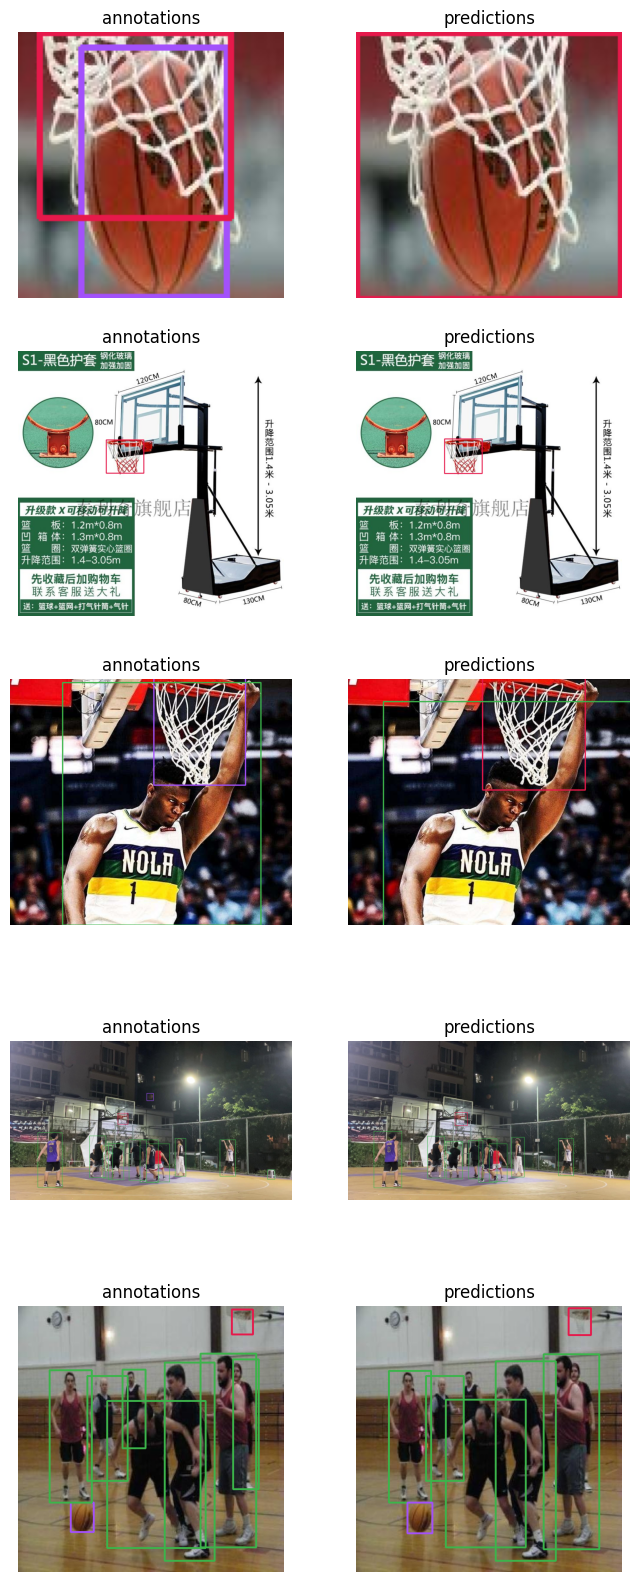

In [10]:
%matplotlib inline
sv.plot_images_grid(images=images, titles=titles, grid_size=(n, 2), size=(2 * 4, n * 4))

In [11]:
!pip install onemetric

Defaulting to user installation because normal site-packages is not writeable
  Obtaining dependency information for dataclasses-json from https://files.pythonhosted.org/packages/ae/53/8c006de775834cd4ea64a445402dc195caeebb77dc76b7defb9b3887cb0d/dataclasses_json-0.6.3-py3-none-any.whl.metadata
  Obtaining dependency information for marshmallow<4.0.0,>=3.18.0 from https://files.pythonhosted.org/packages/ed/3c/cebfdcad015240014ff08b883d1c0c427f2ba45ae8c6572851b6ef136cad/marshmallow-3.20.1-py3-none-any.whl.metadata
  Obtaining dependency information for typing-inspect<1,>=0.4.0 from https://files.pythonhosted.org/packages/65/f3/107a22063bf27bdccf2024833d3445f4eea42b2e598abfbd46f6a63b6cb0/typing_inspect-0.9.0-py3-none-any.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.4/49.4 kB 8.2 MB/s eta 0:00:00


In [22]:
import os

import numpy as np

from onemetric.cv.object_detection import ConfusionMatrix

keys = list(ds.images.keys())

annotation_batches, prediction_batches = [], []

for key in keys:
    annotation=ds.annotations[key]
    annotation_batch = np.column_stack((
        annotation.xyxy,
        annotation.class_id
    ))
    annotation_batches.append(annotation_batch)

    prediction=predictions[key]
    prediction_batch = np.column_stack((
        prediction.xyxy,
        prediction.class_id,
        prediction.confidence
    ))
    prediction_batches.append(prediction_batch)

confusion_matrix = ConfusionMatrix.from_detections(
    true_batches=annotation_batches,
    detection_batches=prediction_batches,
    num_classes=len(ds.classes),
    conf_threshold=CONFIDENCE_TRESHOLD
)

#confusion_matrix.plot(os.path.join(HOME, "confusion_matrix.png"), class_names=ds.classes)

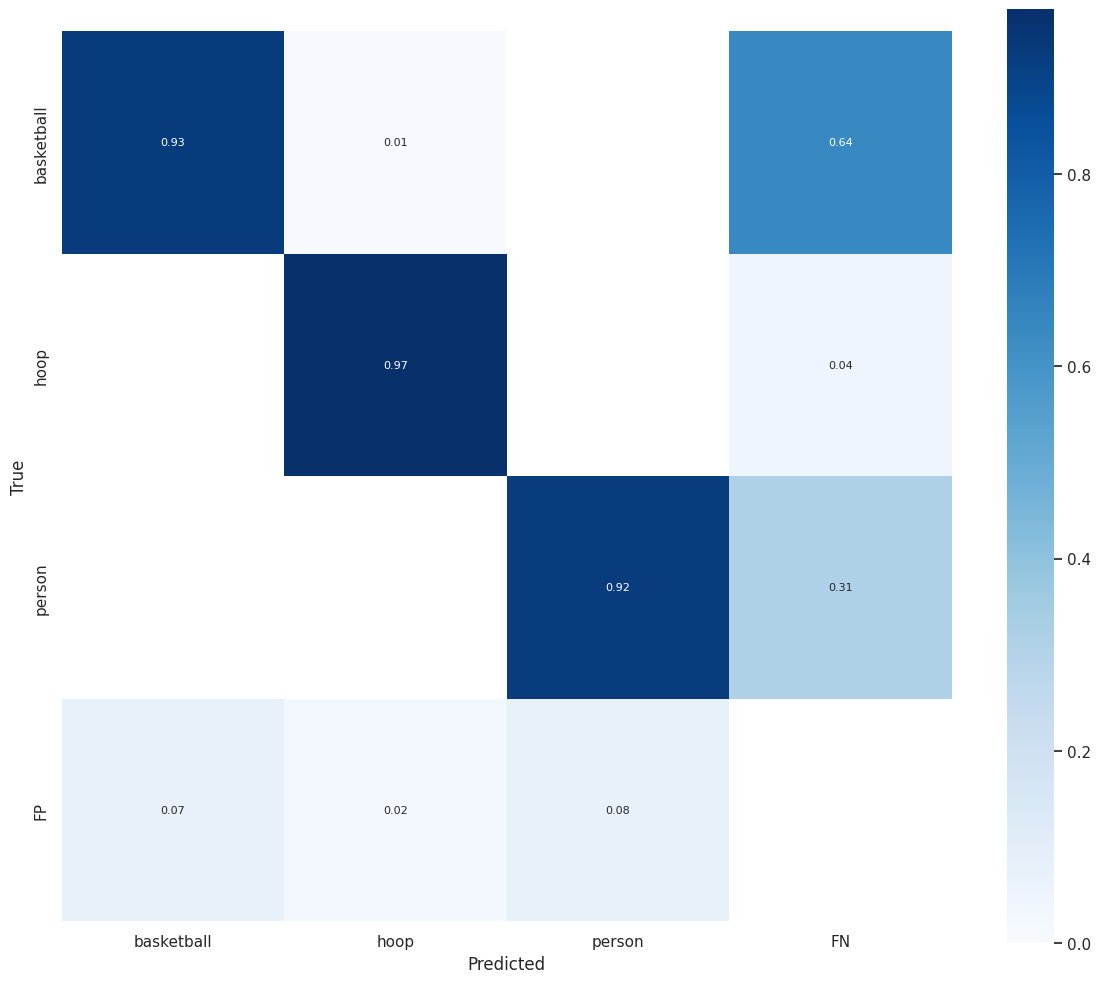

In [24]:
confusion_matrix.plot("yolonas_checkpoints/bball_detect_v21/RUN_20231130_164611_350170", class_names=ds.classes)

In [20]:
conf_matrix = np.array([[162.,   2.,   0., 209.],
       [  0., 368.,   0.,  14.],
       [  0.,   0., 653., 102.],
       [ 13.,   9.,  55.,   0.]])
CLASSES

['basketball', 'hoop', 'person']

<Axes: >

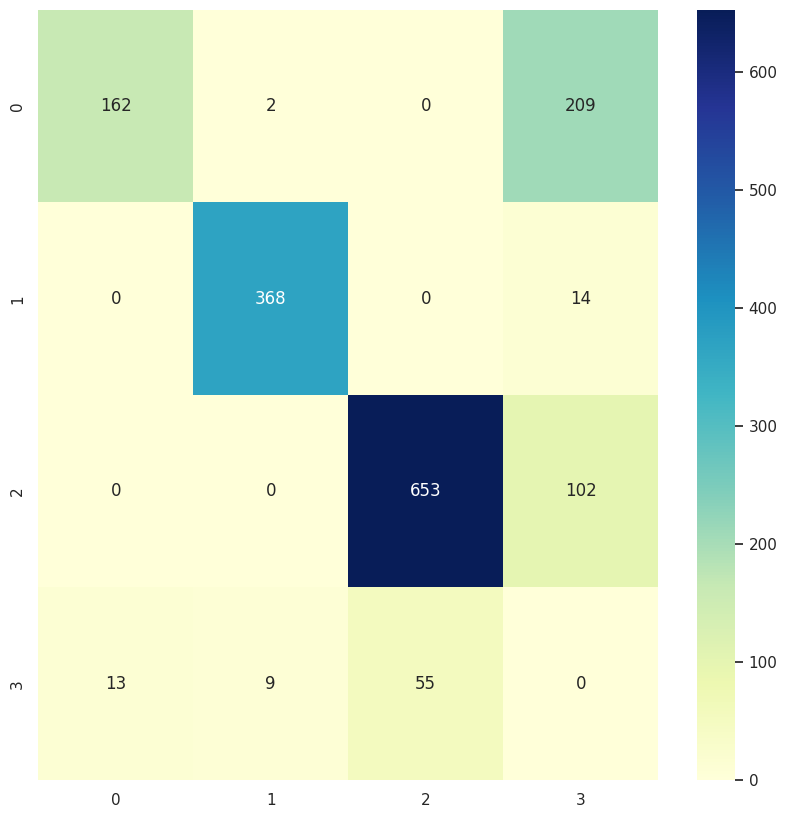

In [19]:
#import confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

#confusion matrix
# plot temp
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(temp, annot=True, fmt='g', ax=ax, cmap="YlGnBu") #fix cmap